In [320]:
import numpy as np
import pandas as pd
import sys, os
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import pickle

In [321]:
sys.path.append(os.path.abspath(os.path.join('../Scripts')))
from file_handler import FileHandler
from df_selector import *
from df_cleaner import *
from Scripts.df_visualizer import *

In [322]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)

## Reading Data

In [323]:
# create a FileHandler object
file_handler = FileHandler()

In [324]:
store_df = file_handler.read_csv(r"..\src\data\store.csv")

In [326]:
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [451]:
store_df.shape

(1115, 15)

In [327]:
# reading the sales training csv file
# reading the sales training csv file
train_df = file_handler.read_csv(r"..\src\data\train.csv")


In [328]:
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


# General Statistics

## store_df

In [329]:
store_df.shape

(1115, 10)

In [330]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


## train_df

In [331]:
# number of elements in the train df
train_df.size

9154881

In [332]:
# rows and columns in the df
train_df.shape

(1017209, 9)

In [333]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


# Missing values

 ## store_df

In [334]:
percent_missing_values(store_df)

The dataset contains 21.01 % missing values.


In [335]:
missing_df = missing_values_table(store_df)

Your selected dataframe has 10 columns.
There are 6 columns that have missing values.


In [336]:
missing_df

,Missing Values,% of Total Values,Dtype
Promo2SinceWeek,544,48.79,float64
Promo2SinceYear,544,48.79,float64
PromoInterval,544,48.79,object
CompetitionOpenSinceMonth,354,31.75,float64
CompetitionOpenSinceYear,354,31.75,float64
CompetitionDistance,3,0.27,float64


from the above we found a pattern, Promo2SinceWeek,Promo2SinceYear and PromoInterval have same no of missing value and CompetitionOpenSinceMonth and CompetitionOpenSinceYear has the same number of missing value we must investigate deeper to get more insight

In [337]:
# number of rows with missing values for the whole dataset
count_missing_rows(store_df)

750 rows(67.26%) contain atleast one missing value.


In [338]:
# number of rows with missing values for group 1 (Promo2SinceWeek, Promo2SinceYear, and PromoInterval)
count_missing_rows(store_df[['Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']])

544 rows(48.79%) contain atleast one missing value.


In [339]:
# number of rows with missing values for group 2 (CompetitionOpenSinceMonth, and CompetitionOpenSinceYear)
count_missing_rows(store_df[['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear']])

354 rows(31.75%) contain atleast one missing value.


Each columuns in these groups have missing values in the same rows as their groupmates. These means the missing values in these groups appear at the same time as a cluster. From the column names and the data fields' description in the challange document we can understand that the values of the columns in each group share a common information

In [340]:
# dataframe containing the missing rows for columns in group 1
group1_df = store_df[store_df['Promo2SinceWeek'].isna()]
group1_df.head(10)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
7,8,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
8,9,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN
9,10,a,a,3160.0,9.0,2009.0,0,NaN,NaN,NaN
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
22,23,d,a,4060.0,8.0,2005.0,0,NaN,NaN,NaN


We can see that the Promo2 column is 0 for the first 10 rows. From intution we can infer that if there is no promotion the values for the columns in gropu 1(Promo2SinceWeek, Promo2SinceYear, and PromoInterval) should be null. Let's prove it.

In [341]:
# all unique values for each column
unique_values_df(group1_df)

,Column,Unique values
0,Store,"[1, 758, 741, 742, 747, 751, 755, 757, 760, 4,..."
1,StoreType,"[a, d, c, b]"
2,Assortment,"[a, c, b]"
3,CompetitionDistance,"[250.0, 140.0, 50.0, 2640.0, 30.0, 420.0, 720...."
4,CompetitionOpenSinceMonth,"[9.0, 4.0, 11.0, 3.0, 12.0, 10.0, 7.0, 6.0, 2...."
5,CompetitionOpenSinceYear,"[2013.0, 2012.0, 2014.0, 2009.0, 2010.0, 2005...."
6,Promo2,[0]
7,Promo2SinceWeek,[]
8,Promo2SinceYear,[]
9,PromoInterval,[]


In [344]:
group1_df['Promo2'].value_counts()

Promo2
0    544
Name: count, dtype: int64

All 544 values are 0. Now let's check the count of 0 in the Promo2 column for the whole store dataset.

In [345]:
store_df['Promo2'].value_counts()

Promo2
1    571
0    544
Name: count, dtype: int64

Yes, we are right. All rows with 0 value in their Promo2 columns have null values in the columns Promo2SinceWeek, Promo2SinceYear, and PromoInterval.

Now let's impute the missing values in the columns Promo2SinceWeek and Promo2SinceYear with 0 to convey the meaning of absence since year and week can't be 0. For PromoInterval we should dig deeper what kind of data it holds since its data type is object.

In [346]:
# check the exact data type of the object
pd.api.types.infer_dtype(store_df['PromoInterval'])

'string'

In [347]:
# all the unique values 
store_df['PromoInterval'].value_counts()

PromoInterval
Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: count, dtype: int64

we need to impute the misiing value for column Promo interval with 0,0,0,0 since other value follows list-type formate containing four months. so first we need to find out wether such value already exist in the rows or not. other wise it will imapct our analysis 


In [348]:
store_df[store_df['Promo2SinceWeek'] == 0].shape

(0, 10)

In [349]:
store_df[store_df['Promo2SinceYear'] == 0].shape

(0, 10)

In [350]:
store_df[store_df['PromoInterval'] == '0,0,0,0'].shape

(0, 10)

From here we found that the value with which we want to replace with the missing value is not available so we can fill the null values by them.

In [351]:
# filling the missing value of promo2since week and Promo2sinceyear with 0 
fix_missing_value(store_df, ['Promo2SinceWeek', 'Promo2SinceYear'], 0)

544 missing values in the column Promo2SinceWeek have been replaced by 0.
544 missing values in the column Promo2SinceYear have been replaced by 0.


In [352]:
# filling the missing values of PromoInterval with 0,0,0,0
fix_missing_value(store_df, ['PromoInterval'], '0,0,0,0')

544 missing values in the column PromoInterval have been replaced by 0,0,0,0.


Now inspecting  CompetitionOpenSinceMonth and CompetitionOpenSinceYear 

In [353]:
# getting all the null values for CompetitionOpenSinceMonth
group2_df = store_df[store_df['CompetitionOpenSinceMonth'].isna()]
group2_df.head(10)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,0.0,0.0,"0,0,0,0"
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
25,26,d,a,2300.0,NaN,NaN,0,0.0,0.0,"0,0,0,0"
28,29,d,c,2170.0,NaN,NaN,0,0.0,0.0,"0,0,0,0"
31,32,a,a,2910.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
39,40,a,a,180.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
40,41,d,c,1180.0,NaN,NaN,1,31.0,2013.0,"Jan,Apr,Jul,Oct"


In [354]:
unique_values_df(group2_df)

,Column,Unique values
0,Store,"[12, 853, 767, 766, 764, 762, 757, 756, 742, 7..."
1,StoreType,"[a, d, c, b]"
2,Assortment,"[c, a, b]"
3,CompetitionDistance,"[250.0, 2410.0, 50.0, 210.0, 840.0, 220.0, 150..."
4,CompetitionOpenSinceMonth,[]
5,CompetitionOpenSinceYear,[]
6,Promo2,"[1, 0]"
7,Promo2SinceWeek,"[0.0, 40.0, 14.0, 45.0, 31.0, 22.0, 5.0, 1.0, ..."
8,Promo2SinceYear,"[0.0, 2013.0, 2011.0, 2009.0, 2012.0, 2014.0, ..."
9,PromoInterval,"[0,0,0,0, Jan,Apr,Jul,Oct, Feb,May,Aug,Nov, Ma..."


 If CompetitionOpenSinceMonth  and CompetitionOpenSinceYear is null it means there was already a compedition when the store was opened so we must create a new column named CompetitionBeforeStoreOpened so that we can make use of this information in our analysis and prediction. This column will hold values of 0 and 1, 0 indicating the absence of competition at the time the store was opened and 1 indicating the presence of competition at the time the store was opened.

In [355]:
# deriving new column
store_df['CompetitionBeforeStoreOpened'] = store_df['CompetitionOpenSinceYear'].apply(lambda x: 1 if np.isnan(x) else 0)
store_df

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionBeforeStoreOpened
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,"0,0,0,0",0
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",0
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",0
3,4,c,c,620.0,9.0,2009.0,0,0.0,0.0,"0,0,0,0",0
4,5,a,a,29910.0,4.0,2015.0,0,0.0,0.0,"0,0,0,0",0
...,...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",0
1111,1112,c,c,1880.0,4.0,2006.0,0,0.0,0.0,"0,0,0,0",0
1112,1113,a,c,9260.0,NaN,NaN,0,0.0,0.0,"0,0,0,0",1
1113,1114,a,c,870.0,NaN,NaN,0,0.0,0.0,"0,0,0,0",1


Now if we want to impute the missing value of CompetitionOpenSinceMonth and CompetitionOpenSinceYear we must repace the missing value of CompetitionOpenSinceYear with its minimum value of the column and CompetitionOpenSinceMonth with 1, in this we are assuming that store with missing value in these columns we opened after the first month of the minimum year value in the CompetitionOpenSinceYear

In [356]:
# finding the minimum year value for CompetitionOpenSinceYear and impute the missing values.
min_year = store_df['CompetitionOpenSinceYear'].min()
min_year

1900.0

In [357]:
# impute the column CompetitionOpenSinceYear with 1900 and the column CompetitionOpenSinceMonth with 1
fix_missing_value(store_df, ['CompetitionOpenSinceYear'], min_year)
fix_missing_value(store_df, ['CompetitionOpenSinceMonth'], 1)

354 missing values in the column CompetitionOpenSinceYear have been replaced by 1900.0.
354 missing values in the column CompetitionOpenSinceMonth have been replaced by 1.


In [358]:
store_df

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionBeforeStoreOpened
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,"0,0,0,0",0
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",0
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",0
3,4,c,c,620.0,9.0,2009.0,0,0.0,0.0,"0,0,0,0",0
4,5,a,a,29910.0,4.0,2015.0,0,0.0,0.0,"0,0,0,0",0
...,...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",0
1111,1112,c,c,1880.0,4.0,2006.0,0,0.0,0.0,"0,0,0,0",0
1112,1113,a,c,9260.0,1.0,1900.0,0,0.0,0.0,"0,0,0,0",1
1113,1114,a,c,870.0,1.0,1900.0,0,0.0,0.0,"0,0,0,0",1


In [359]:
# now checking for the column competition distance
temp_df = store_df[store_df['CompetitionDistance'].isna()]
temp_df

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionBeforeStoreOpened
290,291,d,a,NaN,1.0,1900.0,0,0.0,0.0,"0,0,0,0",1
621,622,a,c,NaN,1.0,1900.0,0,0.0,0.0,"0,0,0,0",1
878,879,d,a,NaN,1.0,1900.0,1,5.0,2013.0,"Feb,May,Aug,Nov",1


In [360]:
unique_values_df(temp_df)

,Column,Unique values
0,Store,"[291, 622, 879]"
1,StoreType,"[d, a]"
2,Assortment,"[a, c]"
3,CompetitionDistance,[]
4,CompetitionOpenSinceMonth,[1.0]
5,CompetitionOpenSinceYear,[1900.0]
6,Promo2,"[0, 1]"
7,Promo2SinceWeek,"[0.0, 5.0]"
8,Promo2SinceYear,"[0.0, 2013.0]"
9,PromoInterval,"[0,0,0,0, Feb,May,Aug,Nov]"


from here we found that when the store was open there was already competion available, but still they decided to open the store. the reason may be  the competitions for these stores are very far away and have almost no impact on these stores. so we will replace the missing value with the maximum disttance

In [361]:
max_dist = store_df['CompetitionDistance'].max()
max_dist

75860.0

In [362]:
fix_missing_value(store_df, ['CompetitionDistance'], max_dist)

3 missing values in the column CompetitionDistance have been replaced by 75860.0.


In [363]:
# final check for missing values
percent_missing_values(store_df)

The dataset contains 0.0 % missing values.


# checking missing value in train_df

In [364]:
percent_missing_values(train_df)


The dataset contains 0.0 % missing values.


Here we found that there is no missing values in the train_df

In [365]:
# checking the columns with mixed data type
show_cols_mixed_dtypes(store_df)

None of the columns contain mixed types.


In [366]:
store_df.dtypes

Store                             int64
StoreType                        object
Assortment                       object
CompetitionDistance             float64
CompetitionOpenSinceMonth       float64
CompetitionOpenSinceYear        float64
Promo2                            int64
Promo2SinceWeek                 float64
Promo2SinceYear                 float64
PromoInterval                    object
CompetitionBeforeStoreOpened      int64
dtype: object

In [367]:
# get the columns with object data type
string_columns = store_df.select_dtypes(include='object').columns.tolist()
string_columns

['StoreType', 'Assortment', 'PromoInterval']

In [368]:
#converting the stortype, assortment,PromoInterval to string
convert_to_string(store_df, string_columns)

In [369]:
store_df.dtypes

Store                                    int64
StoreType                       string[python]
Assortment                      string[python]
CompetitionDistance                    float64
CompetitionOpenSinceMonth              float64
CompetitionOpenSinceYear               float64
Promo2                                   int64
Promo2SinceWeek                        float64
Promo2SinceYear                        float64
PromoInterval                   string[python]
CompetitionBeforeStoreOpened             int64
dtype: object

converting CompetitionOpenSinceMonth, CompetitionOpenSinceYear, Promo2SinceWeek, and Promo2SinceYear to int64

In [209]:
convert_to_int(store_df, ['CompetitionOpenSinceMonth',  'CompetitionOpenSinceYear',
        'Promo2SinceWeek', 'Promo2SinceYear'])

In [370]:
store_df.dtypes

Store                                    int64
StoreType                       string[python]
Assortment                      string[python]
CompetitionDistance                    float64
CompetitionOpenSinceMonth              float64
CompetitionOpenSinceYear               float64
Promo2                                   int64
Promo2SinceWeek                        float64
Promo2SinceYear                        float64
PromoInterval                   string[python]
CompetitionBeforeStoreOpened             int64
dtype: object

Now lets check for train_df

In [371]:
show_cols_mixed_dtypes(train_df)

         Column      Data type
0  StateHoliday  mixed-integer


In [372]:
train_df['StateHoliday'].value_counts()

StateHoliday
0    855087
0    131072
a     20260
b      6690
c      4100
Name: count, dtype: int64

In [373]:
train_df['StateHoliday'].value_counts().index

Index(['0', 0, 'a', 'b', 'c'], dtype='object', name='StateHoliday')

Here we can see ['0', 0,] one zero is integer adn one zero is string so we need to convert both to string 

In [374]:
# converting column stateholiday to string
convert_to_string(train_df, ['StateHoliday'])

In [375]:
train_df.dtypes

Store                     int64
DayOfWeek                 int64
Date                     object
Sales                     int64
Customers                 int64
Open                      int64
Promo                     int64
StateHoliday     string[python]
SchoolHoliday             int64
dtype: object

In [376]:
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [377]:
# converting column Date to datetime datatype
convert_to_datetime(train_df, ['Date'])

In [378]:
train_df.dtypes

Store                     int64
DayOfWeek                 int64
Date             datetime64[ns]
Sales                     int64
Customers                 int64
Open                      int64
Promo                     int64
StateHoliday     string[python]
SchoolHoliday             int64
dtype: object

## Checking Duplicates

> store_df

In [379]:
# search for duplicate rows and drop them
drop_duplicates(store_df)

No duplicate rows were found.


Here it is showing us we have no duplicate values to confirm it lets check with store ID because each store has unique id

In [380]:
store_df.duplicated(subset=['Store']).all()

False

Here we confirms that there is now duplicate values present in store_df

> train_df

In [381]:
drop_duplicates(train_df)

No duplicate rows were found.


we can have same store having same Date, so to confirm there is no duplicate in test_df we must check whether such case exist or not

In [382]:
train_df.duplicated(subset=['Store', 'Date']).all()

False

Here we found that there no such case exist.

## Feature engineering

In [383]:
# now extracting date, month, year, Day of month, week of year, weekday from Date column 
train_df['Year'] = train_df['Date'].apply(lambda x: x.year)
train_df['Month'] = train_df['Date'].apply(lambda x: x.month)
train_df['DayOfMonth'] = train_df['Date'].apply(lambda x: x.day)
train_df['WeekOfYear'] = train_df['Date'].apply(lambda x: x.weekofyear)
train_df['weekday'] = train_df['DayOfWeek'].apply(lambda x: 0 if (x in [6, 7]) else 1)

In [385]:
def get_part_of_month(day):
    if (day < 10):
      return 0
    elif(day < 20):
      return 1
    else:
      return 2
  
def extract_part_of_month(df):
    df = df[df['Open'] == 1]
    df["part_of_month"] = df["DayOfMonth"].apply(get_part_of_month)
    return df

In [386]:
train_df=extract_part_of_month(train_df)

In [446]:
train_df.sample(10)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,DayOfMonth,WeekOfYear,weekday,part_of_month
411827,63,5,2014-06-27,5872,600,1,0,0,0,2014,6,27,26,1,2
301777,1053,4,2014-10-23,9352,1058,1,1,0,0,2014,10,23,43,1,2
1000232,863,3,2013-01-16,6474,835,1,0,0,0,2013,1,16,3,1,1
750192,583,3,2013-08-28,4199,447,1,1,0,1,2013,8,28,35,1,2
251634,355,1,2014-12-15,17360,1617,1,1,0,0,2014,12,15,51,1,1
756942,643,4,2013-08-22,5162,818,1,0,0,0,2013,8,22,34,1,2
210195,576,6,2015-01-24,5612,811,1,0,0,0,2015,1,24,4,0,2
36349,670,1,2015-06-29,10520,932,1,1,0,0,2015,6,29,27,1,2
85649,910,6,2015-05-16,4276,437,1,0,0,0,2015,5,16,20,0,1
250816,488,2,2014-12-16,6067,500,1,1,0,0,2014,12,16,51,1,1


> store_df

In [447]:
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionBeforeStoreOpened,PromoInterval0,PromoInterval1,PromoInterval2,PromoInterval3
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,"0,0,0,0",0,0,0,0,0
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",0,1,4,7,10
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",0,1,4,7,10
3,4,c,c,620.0,9.0,2009.0,0,0.0,0.0,"0,0,0,0",0,0,0,0,0
4,5,a,a,29910.0,4.0,2015.0,0,0.0,0.0,"0,0,0,0",0,0,0,0,0


In promo interval column in each row we have 4 different month i.e jan,apr,jul,oct so we will split  the promo interval into  four different column and each column will carry the index value of the month i.e jan=1, feb=2, march=3 and so on and 0,0,0,0 will be replaced by 0

In [448]:
def getMonth(month_list, index):
    months = ['0', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
    month_list = month_list.split(',')
    month = month_list[index]
    return months.index(month)

In [449]:
# split the PromoInterval column into 4 columns
store_df['PromoInterval0'] = store_df.PromoInterval.apply((lambda x: getMonth(x, 0)))
store_df['PromoInterval1'] = store_df.PromoInterval.apply((lambda x: getMonth(x, 1)))
store_df['PromoInterval2'] = store_df.PromoInterval.apply((lambda x: getMonth(x, 2)))
store_df['PromoInterval3'] = store_df.PromoInterval.apply((lambda x: getMonth(x, 3)))

In [450]:
store_df.sample(10)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionBeforeStoreOpened,PromoInterval0,PromoInterval1,PromoInterval2,PromoInterval3
264,265,a,a,4580.0,1.0,1900.0,1,14.0,2015.0,"Jan,Apr,Jul,Oct",1,1,4,7,10
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,"0,0,0,0",0,0,0,0,0
795,796,a,c,7180.0,11.0,2012.0,0,0.0,0.0,"0,0,0,0",0,0,0,0,0
511,512,b,b,590.0,1.0,1900.0,1,5.0,2013.0,"Mar,Jun,Sept,Dec",1,3,6,9,12
281,282,a,a,1220.0,12.0,2010.0,0,0.0,0.0,"0,0,0,0",0,0,0,0,0
204,205,a,a,110.0,12.0,2007.0,0,0.0,0.0,"0,0,0,0",0,0,0,0,0
197,198,a,a,290.0,9.0,2002.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",0,1,4,7,10
740,741,d,c,11900.0,1.0,1900.0,0,0.0,0.0,"0,0,0,0",1,0,0,0,0
136,137,a,a,1730.0,7.0,2015.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct",0,1,4,7,10
10,11,a,c,960.0,11.0,2011.0,1,1.0,2012.0,"Jan,Apr,Jul,Oct",0,1,4,7,10


here we can see from promointerval0 in promo interval columns months are Feb, may,aug,nov so for Promointerval0 we got 2(feb),for promointerval1 we got 5(may),promointerval2 we got 8(august),promointerval3 we got 11(nov)

## merging data and saving

In [ ]:
unique_values_df(tra)

In [452]:
store_df.shape

(1115, 15)

In [453]:
# merging store_df and train_df
df = pd.merge(train_df, store_df, how='inner', on='Store')
df.shape

(844392, 29)

In [455]:
unique_values_df(df)

,Column,Unique values
0,Store,"[562, 769, 733, 423, 85, 262, 335, 682, 1097, ..."
1,DayOfWeek,"[6, 2, 3, 5, 1, 4, 7]"
2,Date,"[2014-04-16 00:00:00, 2015-01-13 00:00:00, 201..."
3,Sales,"[5674, 5558, 5483, 6049, 6214, 5723, 5449, 548..."
4,Customers,"[560, 576, 603, 571, 555, 566, 517, 539, 651, ..."
5,Open,[1]
6,Promo,"[0, 1]"
7,StateHoliday,"[0, a, b, c]"
8,SchoolHoliday,"[0, 1]"
9,Year,"[2013, 2014, 2015]"


In [232]:
#store_df.to_csv('D:\Pharmaceutical Data\store_clean.csv')
#train_df.to_csv(r'D:\Pharmaceutical Data\train_clean.csv')
#df.to_csv("D:\Pharmaceutical Data\merge.csv")

In [456]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,DayOfMonth,WeekOfYear,weekday,part_of_month,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionBeforeStoreOpened,PromoInterval0,PromoInterval1,PromoInterval2,PromoInterval3
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,7,31,31,1,2,c,a,1270.0,9.0,2008.0,0,0.0,0.0,"0,0,0,0",0,0,0,0,0
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,7,31,31,1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",0,1,4,7,10
2,3,5,2015-07-31,8314,821,1,1,0,1,2015,7,31,31,1,2,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",0,1,4,7,10
3,4,5,2015-07-31,13995,1498,1,1,0,1,2015,7,31,31,1,2,c,c,620.0,9.0,2009.0,0,0.0,0.0,"0,0,0,0",0,0,0,0,0
4,5,5,2015-07-31,4822,559,1,1,0,1,2015,7,31,31,1,2,a,a,29910.0,4.0,2015.0,0,0.0,0.0,"0,0,0,0",0,0,0,0,0


In [397]:
df.to_csv('D:\Pharmaceutical\src\data\merged.csv',index=False)

## Univariate  analysis

### Non-graphical univariate analysis

In [399]:
df.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
Store,844392.0,558.42292,1.0,280.0,558.0,837.0,1115.0,321.731914
DayOfWeek,844392.0,3.520361,1.0,2.0,3.0,5.0,7.0,1.723689
Date,844392,2014-04-11 01:02:42.487565056,2013-01-01 00:00:00,2013-08-16 00:00:00,2014-03-31 00:00:00,2014-12-10 00:00:00,2015-07-31 00:00:00,NaN
Sales,844392.0,6955.514291,0.0,4859.0,6369.0,8360.0,41551.0,3104.21468
Customers,844392.0,762.728395,0.0,519.0,676.0,893.0,7388.0,401.227674
Open,844392.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
Promo,844392.0,0.446352,0.0,0.0,0.0,1.0,1.0,0.497114
SchoolHoliday,844392.0,0.19358,0.0,0.0,0.0,0.0,1.0,0.395103
Year,844392.0,2013.831937,2013.0,2013.0,2014.0,2014.0,2015.0,0.77726
Month,844392.0,5.845738,1.0,3.0,6.0,8.0,12.0,3.323931


## store type

In [237]:
# unique value counts
counts_df = store_df['StoreType'].value_counts()
counts_df

StoreType
a    602
d    348
c    148
b     17
Name: count, dtype: Int64

In [238]:
plotly_plot_pie(store_df, 'StoreType')

### Assortment

In [239]:
# unique value counts
counts_df = store_df['Assortment'].value_counts()
counts_df

Assortment
a    593
c    513
b      9
Name: count, dtype: Int64

In [240]:
plotly_plot_pie(store_df, 'Assortment')

### CompetitionDistance

In [241]:
plotly_plot_hist(store_df, 'CompetitionDistance')

### Promo 2

In [242]:
# unique value counts
counts_df = store_df['Promo2'].value_counts()
counts_df

Promo2
1    571
0    544
Name: count, dtype: int64

### CompetitionBeforeStoreOpened

In [243]:
# unique value counts
counts_df = store_df['CompetitionBeforeStoreOpened'].value_counts()
counts_df

CompetitionBeforeStoreOpened
0    761
1    354
Name: count, dtype: int64

### DayOfWeek

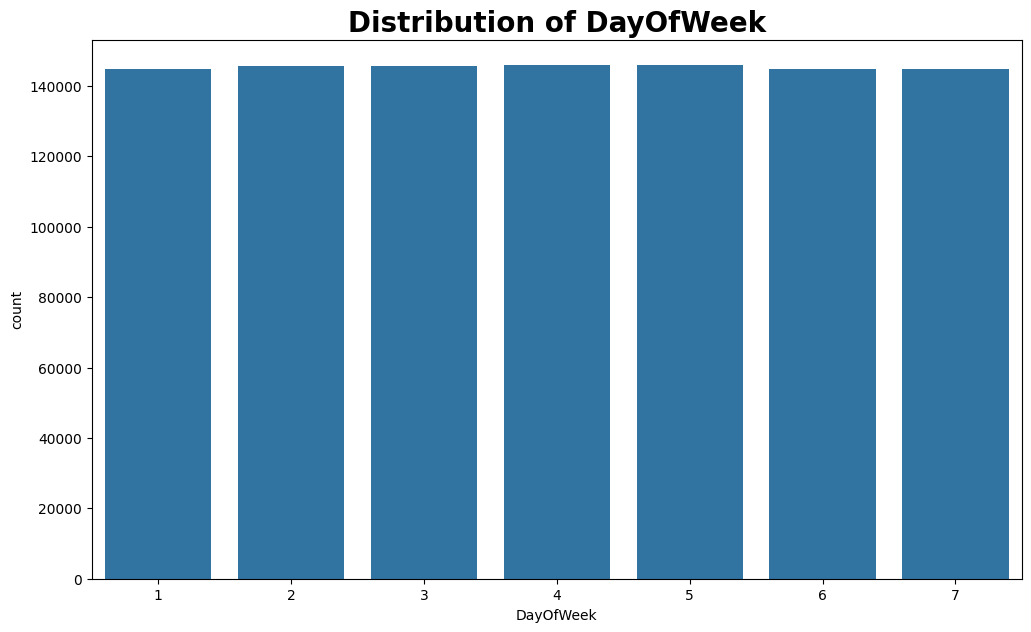

In [244]:
plot_count(train_df, 'DayOfWeek')

### Sales

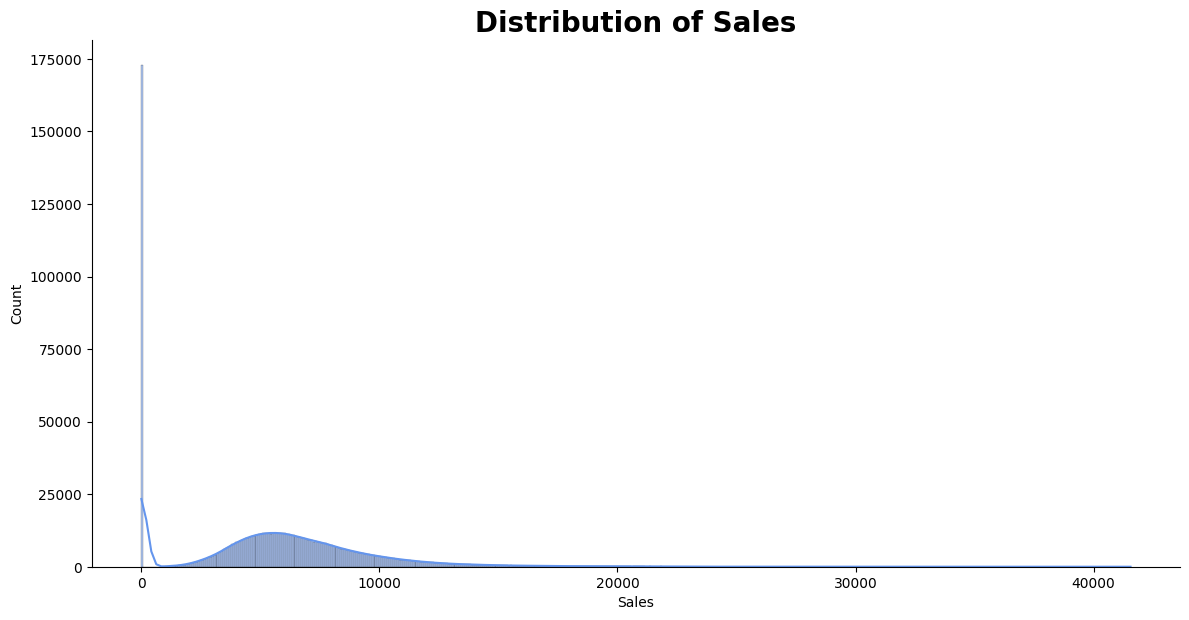

In [245]:
plot_hist(train_df, 'Sales')

### Customers

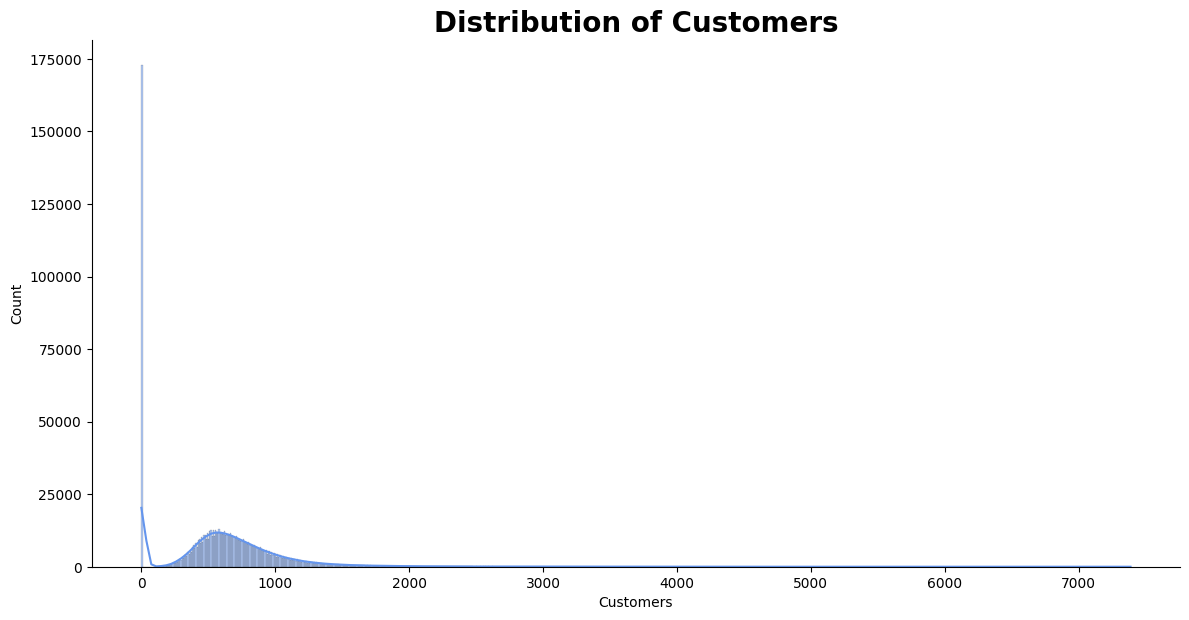

In [246]:
plot_hist(train_df, 'Customers')

### Open

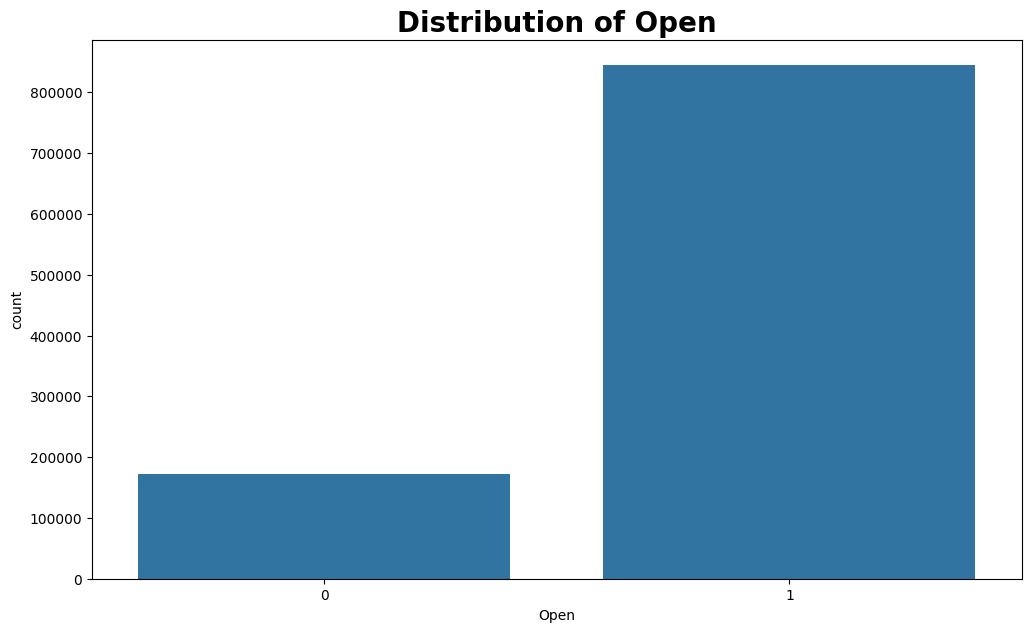

In [247]:
plot_count(train_df, 'Open',)

### Promo

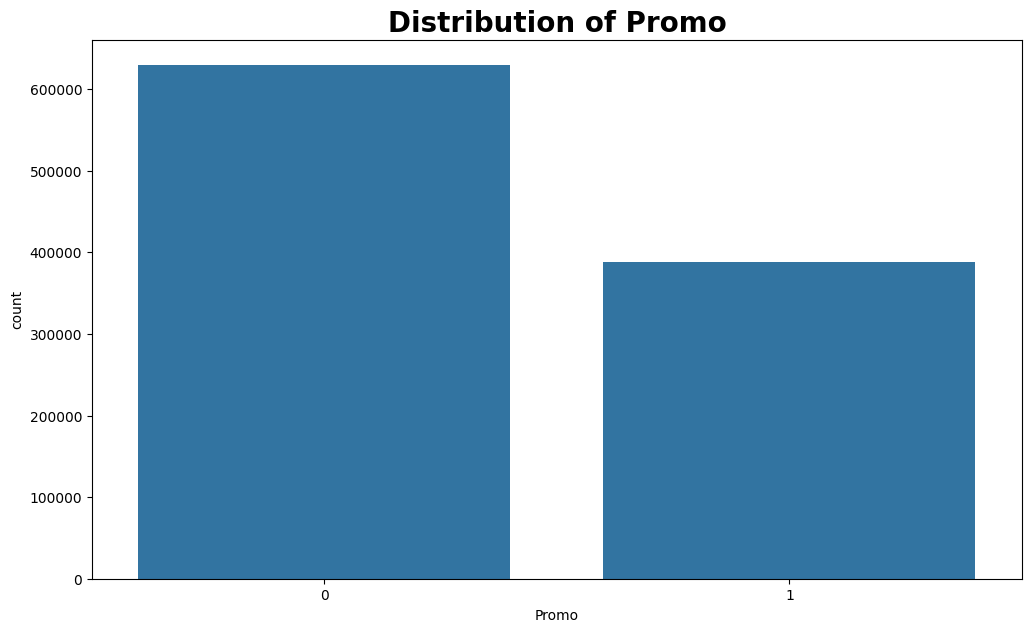

In [248]:
plot_count(train_df, 'Promo')

### State Holiday

In [249]:
# unique value counts
counts_df = train_df['StateHoliday'].value_counts()
counts_df

StateHoliday
0    986159
a     20260
b      6690
c      4100
Name: count, dtype: Int64

### School Holiday

In [250]:
# unique value counts
counts_df = train_df['SchoolHoliday'].value_counts()
counts_df

SchoolHoliday
0    835488
1    181721
Name: count, dtype: int64

### Bivariate analysis

### StateHoliday and Sales

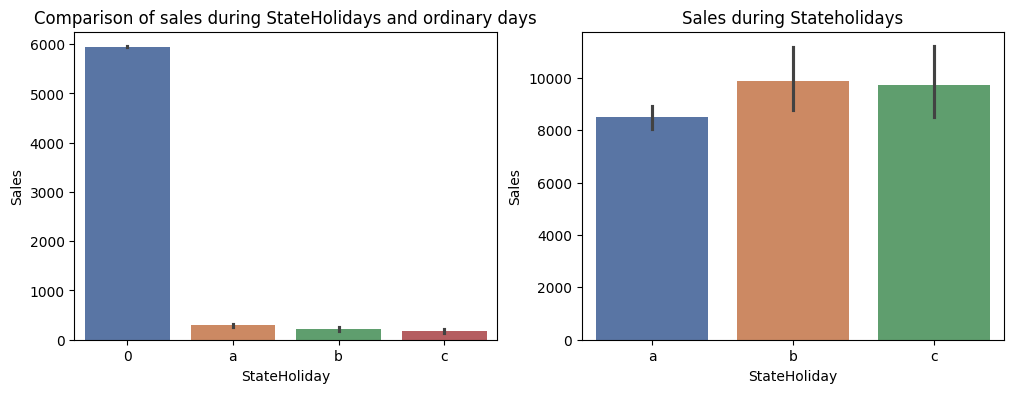

In [251]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(12,4))

# holidays and no_holidays
sns.barplot(x='StateHoliday', y='Sales', data=train_df, ax=axis1,palette="deep").set_title('Comparison of sales during StateHolidays and ordinary days')

# holidays only
mask = (train_df["StateHoliday"] != "0") & (train_df["Sales"] > 0)
sns.barplot(x='StateHoliday', y='Sales', data=train_df[mask], ax=axis2,palette="deep").set_title('Sales during Stateholidays')
plt.show()

### SchoolHoliday vs sales and Customers

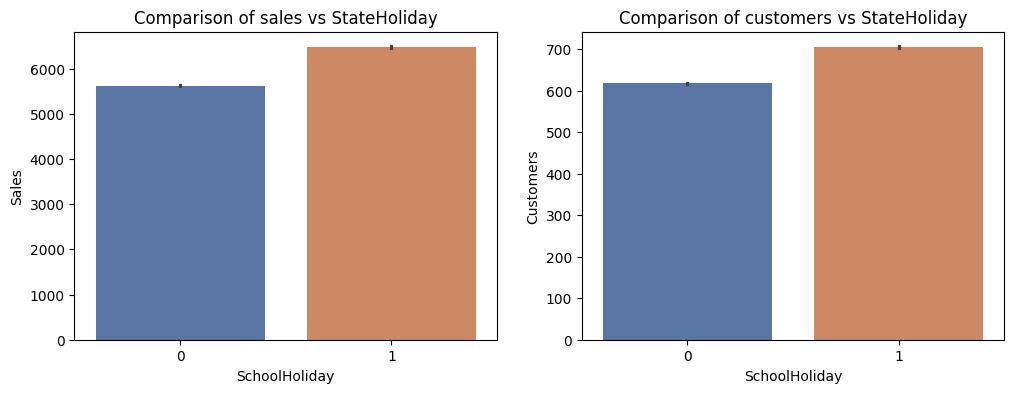

In [252]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(12,4))

sns.barplot(x='SchoolHoliday', y='Sales', data=train_df, ax=axis1,palette="deep").set_title('Comparison of sales vs StateHoliday')
sns.barplot(x='SchoolHoliday', y='Customers', data=train_df, ax=axis2,palette="deep").set_title('Comparison of customers vs StateHoliday')
plt.show()

### StoreType vs Sales and Customers

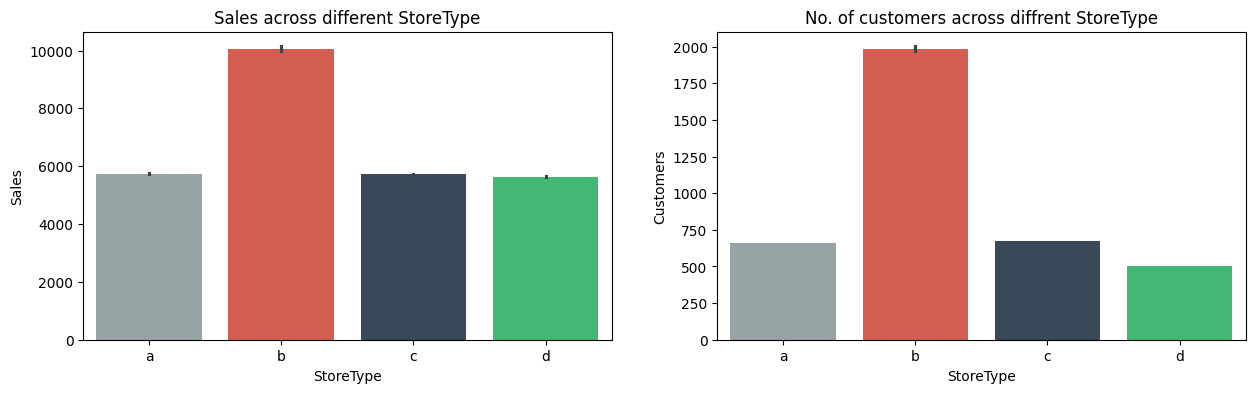

In [253]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
sns.barplot(x='StoreType', y='Sales', data=df, ax=axis1, palette = ["#95a5a6", "#e74c3c", "#34495e", "#2ecc71"], order=['a','b','c', 'd']).set_title('Sales across different StoreType')
sns.barplot(x='StoreType', y='Customers', data=df, ax=axis2, palette = ["#95a5a6", "#e74c3c", "#34495e", "#2ecc71"], order=['a','b','c', 'd']).set_title('No. of customers across diffrent StoreType')
plt.show()

### Assortment vs Sales and Customers

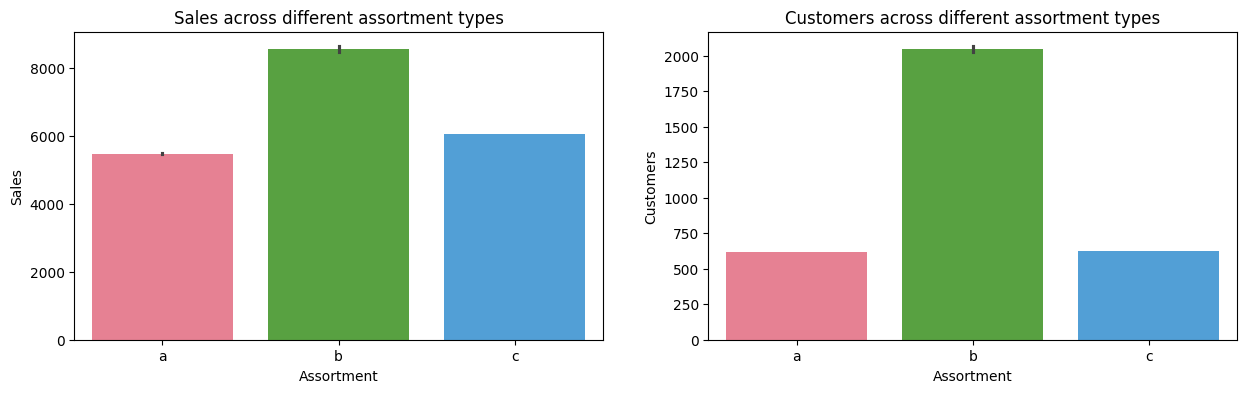

In [254]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='Assortment', y='Sales', data=df, palette = 'husl', order=['a','b','c'], ax=axis1).set_title('Sales across different assortment types')
sns.barplot(x='Assortment', y='Customers', data=df, palette = 'husl', order=['a','b','c'], ax=axis2).set_title('Customers across different assortment types')
plt.show()

### DayOfWeek vs Sales and Customers

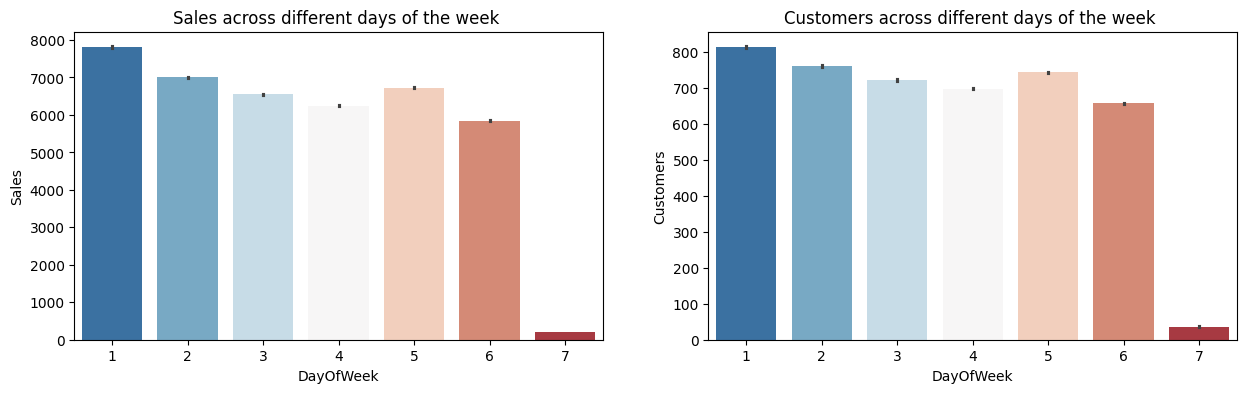

In [255]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
sns.barplot(x='DayOfWeek', y='Sales', data=train_df, palette = 'RdBu_r', ax=axis1).set_title('Sales across different days of the week ')
sns.barplot(x='DayOfWeek', y='Customers', data=train_df, palette = 'RdBu_r', ax=axis2).set_title('Customers across different days of the week ')
plt.show()

### Promo vs Sales and Customers

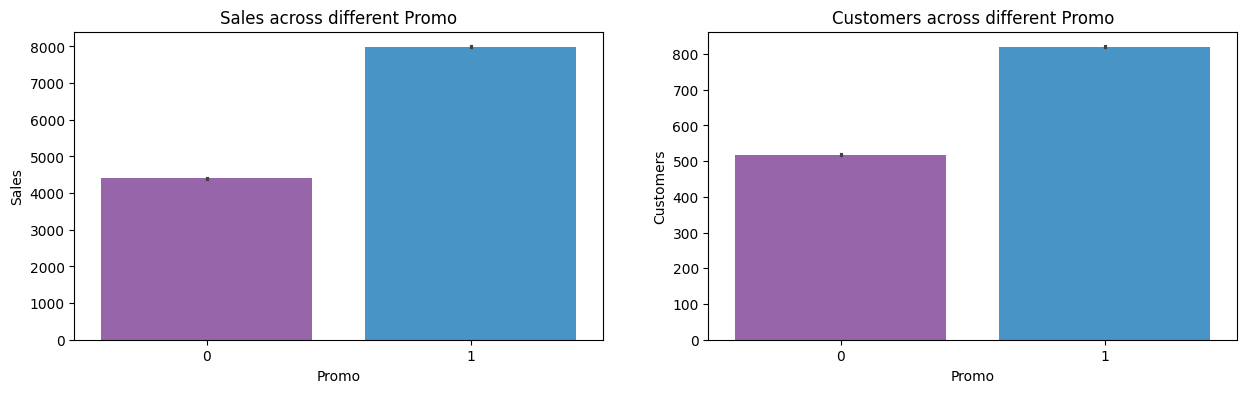

In [256]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='Promo', y='Sales', data=train_df, palette = flatui, ax=axis1).set_title('Sales across different Promo')
sns.barplot(x='Promo', y='Customers', data=train_df, ax=axis2,  palette = flatui).set_title('Customers across different Promo')
plt.show()

### Promo2 vs Sales and Customers

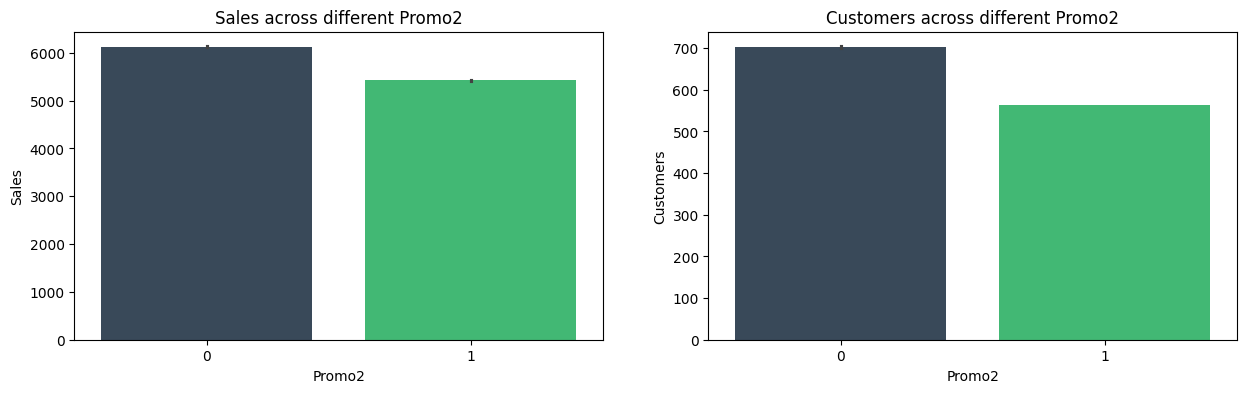

In [257]:
flatui = [ "#34495e", "#2ecc71"]
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='Promo2', y='Sales', data=df, ax=axis1, palette = flatui).set_title('Sales across different Promo2')
sns.barplot(x='Promo2', y='Customers', data=df, ax=axis2, palette = flatui).set_title('Customers across different Promo2')
plt.show()

### PromoInterval vs Sales and Customers

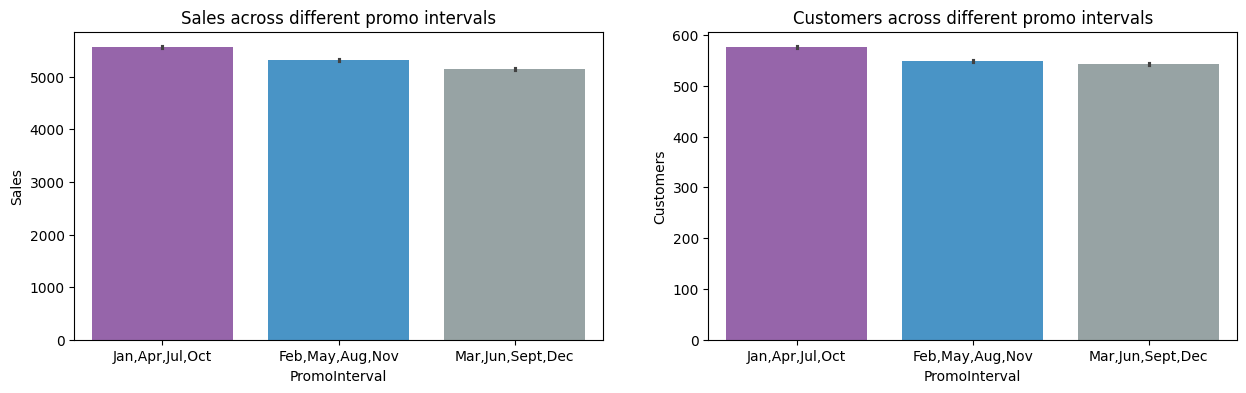

In [258]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

# values with promo2 only
mask = (df["Promo2"] != 0)

sns.barplot(x='PromoInterval', y='Sales', data=df[mask], ax=axis1, palette = flatui).set_title('Sales across different promo intervals')
sns.barplot(x='PromoInterval', y='Customers', data=df[mask], ax=axis2, palette = flatui).set_title('Customers across different promo intervals')
plt.show()

### Open and DayOfWeek

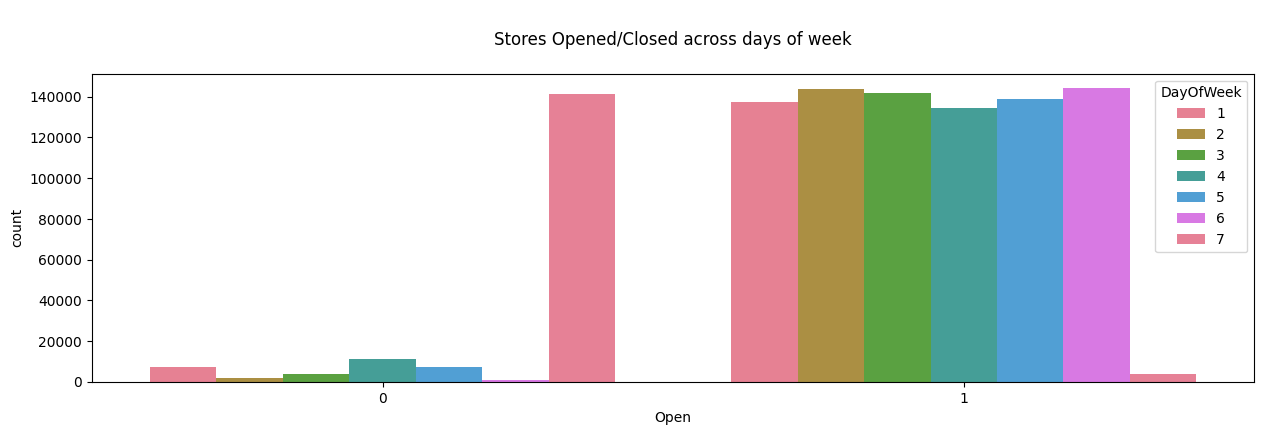

In [259]:
fig, (axis1) = plt.subplots(1,1,figsize=(15,4))
sns.countplot(x='Open',hue='DayOfWeek', data=train_df,palette="husl", ax=axis1).set_title('\nStores Opened/Closed across days of week\n')
plt.show()

### Sales and Month

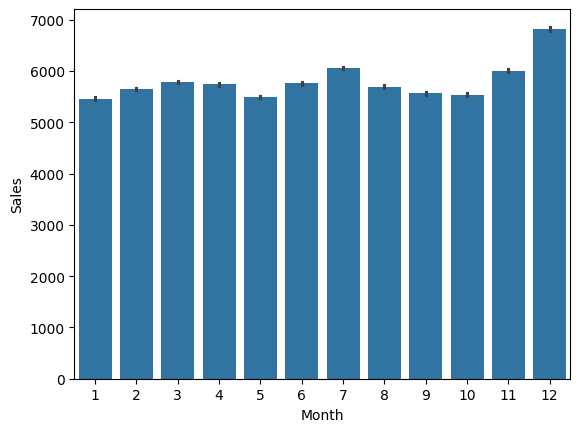

In [260]:
sns.barplot(x='Month', y='Sales', data=df)
plt.show()

### CompetitionDistance and Sales

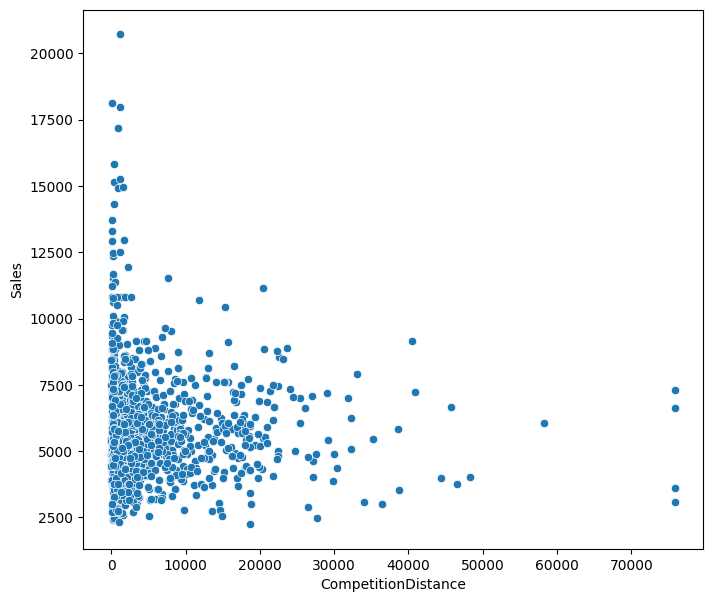

In [261]:
a = df.groupby('Store').agg({
    'CompetitionDistance': 'mean',
    'Sales': 'mean',
    'Customers': 'mean'
})
plt.subplots(figsize = (8, 7))
sns.scatterplot(x='CompetitionDistance', y='Sales', data=a)
plt.show()

>Interpretations: Stores with the smallest competition distance have the highest sales.The reason may be the stores are located at the city centre or near the hospitals where demands are usually high.

## Correlation Analysis

In [262]:
def top_correlated_features(df, target_column='Sales', top_n=7):
    # Filter numerical columns
    numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
    
    # Calculate correlation matrix for numerical columns
    correlation_matrix = df[numerical_columns].corr()
    
    # Select top correlated features with the target column
    top_correlated = correlation_matrix[target_column].nlargest(top_n).index
    
    return top_correlated

In [263]:
def plot_top_correlated_features(df, top_features, target_column='Sales'):
    # Calculate correlation matrix for numerical columns
    correlation_matrix = df[top_features].corr()
    
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
    # Set up the matplotlib figure
    plt.figure(figsize=(8, 5))
    
    # Plot heatmap
    sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, square=True)
    
    # Set plot title and labels
    plt.title('Correlation Matrix of Top 7 Features with Sales')
    plt.xlabel('Features')
    plt.ylabel('Features')
    
    plt.show()

In [264]:
top_numerical_features = top_correlated_features(df)
print(top_numerical_features)

Index(['Sales', 'Customers', 'Open', 'Promo', 'weekday', 'SchoolHoliday',
       'WeekOfYear'],
      dtype='object')


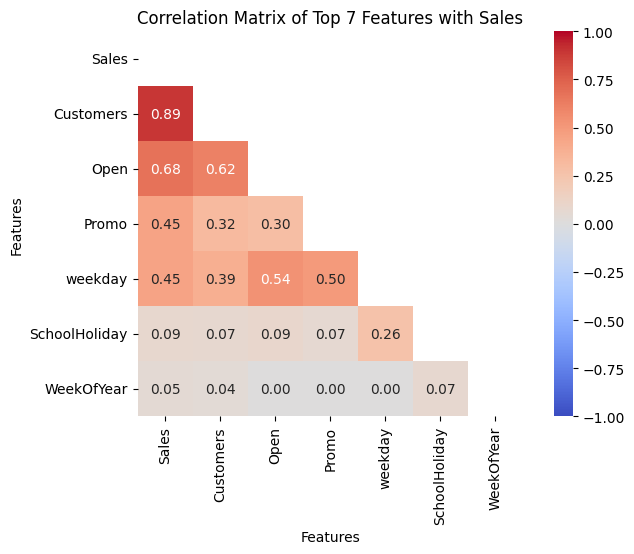

In [265]:
plot_top_correlated_features(df, top_numerical_features)

>Interpretations: Here we found that Customer are positively correlated with the sales with correlation of 0.89. 

●	Check for distribution in both training and test sets - are the promotions distributed similarly between these two groups?

In [400]:
# reading test data
test_df = file_handler.read_csv(r"..\src\data\test.csv")

In [401]:
test_df.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


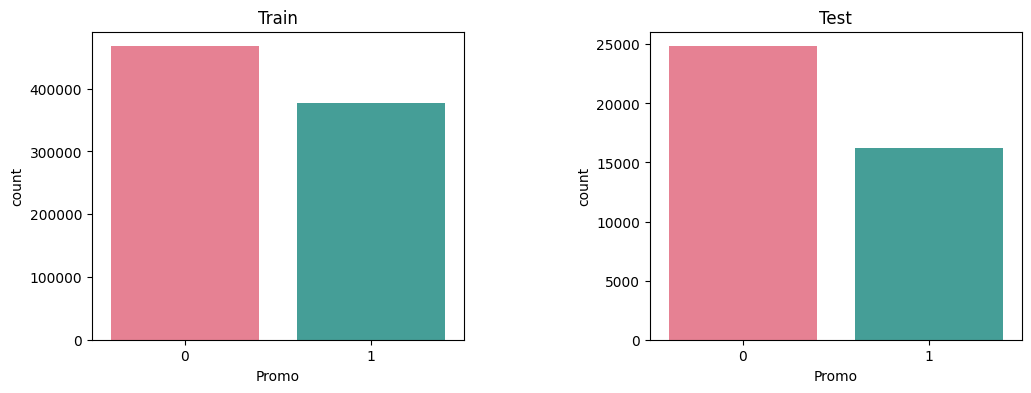

In [402]:
fig, ax = plt.subplots(1, 2, sharex=True, figsize=(12, 4))
ax[0].set_title("Train")
sns.countplot(x='Promo', data=train_df, palette="husl",ax=ax[0])
ax[1].set_title("Test")
sns.countplot(x='Promo', data=test_df, palette="husl",ax=ax[1])
fig.subplots_adjust(wspace=0.5)
fig.show()

>Interpretation - Distribution of promotion is same for both test and train data

In [403]:
### Monthly sales trend per store type
store_type_a = df[df.StoreType == 'a']
store_type_b = df[df.StoreType == 'b']
store_type_c = df[df.StoreType == 'c']
store_type_d = df[df.StoreType == 'd']

Assortment_type_a = df[df.Assortment == 'a']
Assortment_type_b = df[df.Assortment == 'b']
Assortment_type_c = df[df.Assortment == 'c']

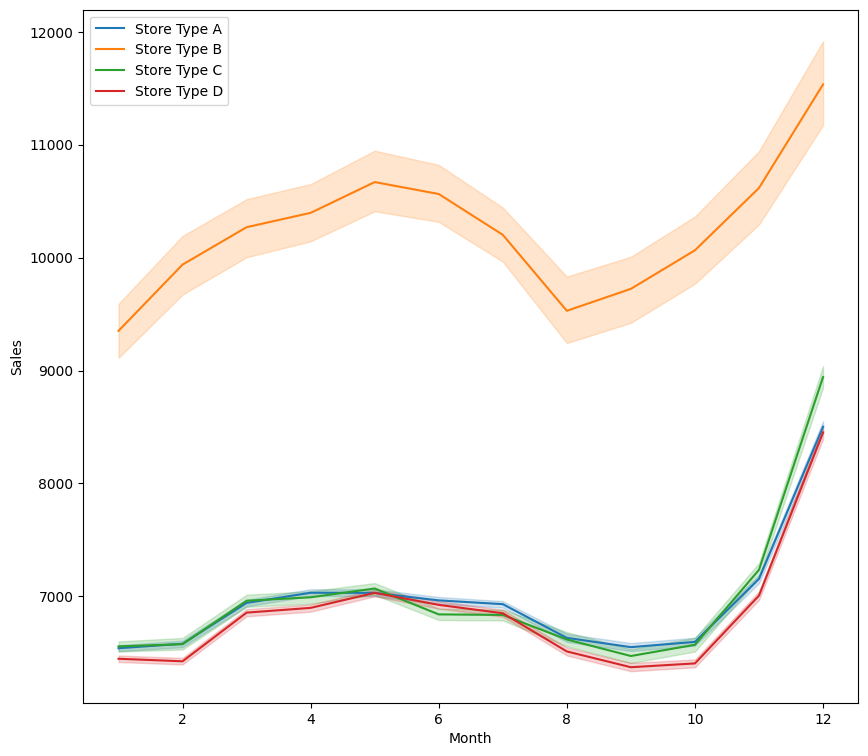

In [404]:
plt.subplots(figsize = (10, 9))
sns.lineplot(x = store_type_a.Month, y = store_type_a.Sales, label="Store Type A")
sns.lineplot(x = store_type_b.Month, y = store_type_b.Sales, label="Store Type B")
sns.lineplot(x = store_type_c.Month, y = store_type_c.Sales, label="Store Type C")
sns.lineplot(x = store_type_d.Month, y = store_type_d.Sales, label="Store Type D")
plt.show()

>Intrepretation - Here we found that store B is the most selling and crowded store type

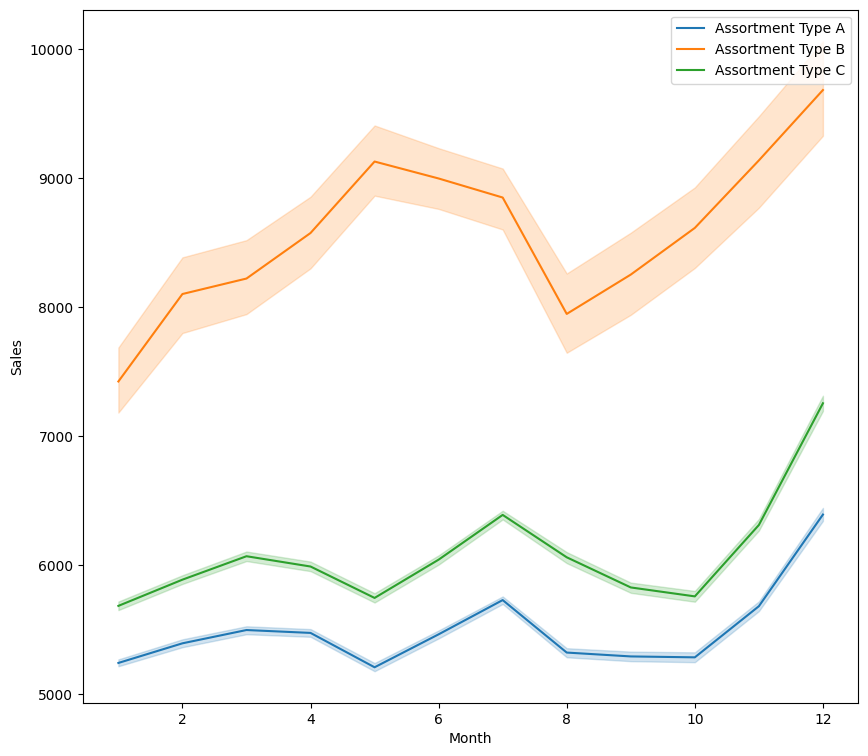

In [271]:
plt.subplots(figsize = (10, 9))
sns.lineplot(x = Assortment_type_a.Month, y = Assortment_type_a.Sales, label="Assortment Type A")
sns.lineplot(x = Assortment_type_b.Month, y = Assortment_type_b.Sales, label="Assortment Type B")
sns.lineplot(x = Assortment_type_c.Month, y = Assortment_type_c.Sales, label="Assortment Type C")
plt.show()

> Here we found that assortment type B is the most selling and crowded assortment 

### Monthly sales per StoreType and Promo

<Figure size 1000x600 with 0 Axes>

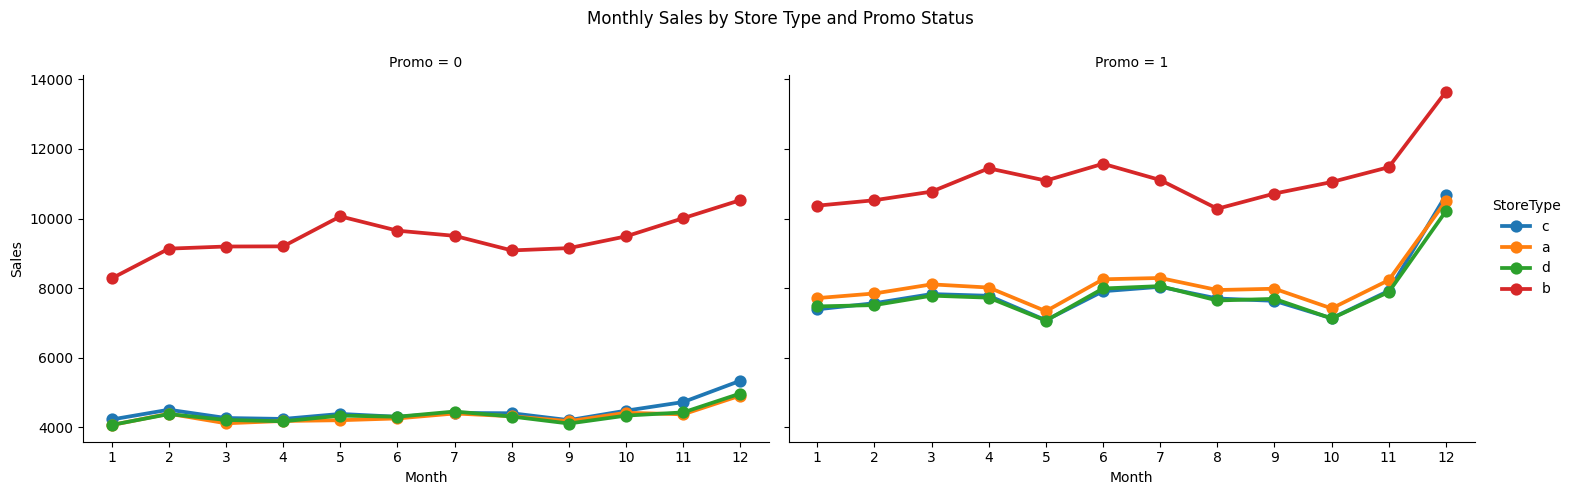

In [272]:

# Convert 'Month' to categorical to ensure correct ordering
df['Month'] = pd.Categorical(df['Month'], categories=range(1, 13), ordered=True)

# Create factor plot
plt.figure(figsize=(10, 6))
sns.catplot(data=df, x='Month', y='Sales', hue='StoreType', col='Promo', kind='point', ci=None, aspect=1.5)
plt.subplots_adjust(top=0.85)
plt.suptitle('Monthly Sales by Store Type and Promo Status')
plt.show()


### Monthly customers per StoreType and Promo

In [273]:
df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'DayOfMonth',
       'WeekOfYear', 'weekday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'CompetitionBeforeStoreOpened',
       'PromoInterval0', 'PromoInterval1', 'PromoInterval2', 'PromoInterval3'],
      dtype='object')

<Figure size 1000x600 with 0 Axes>

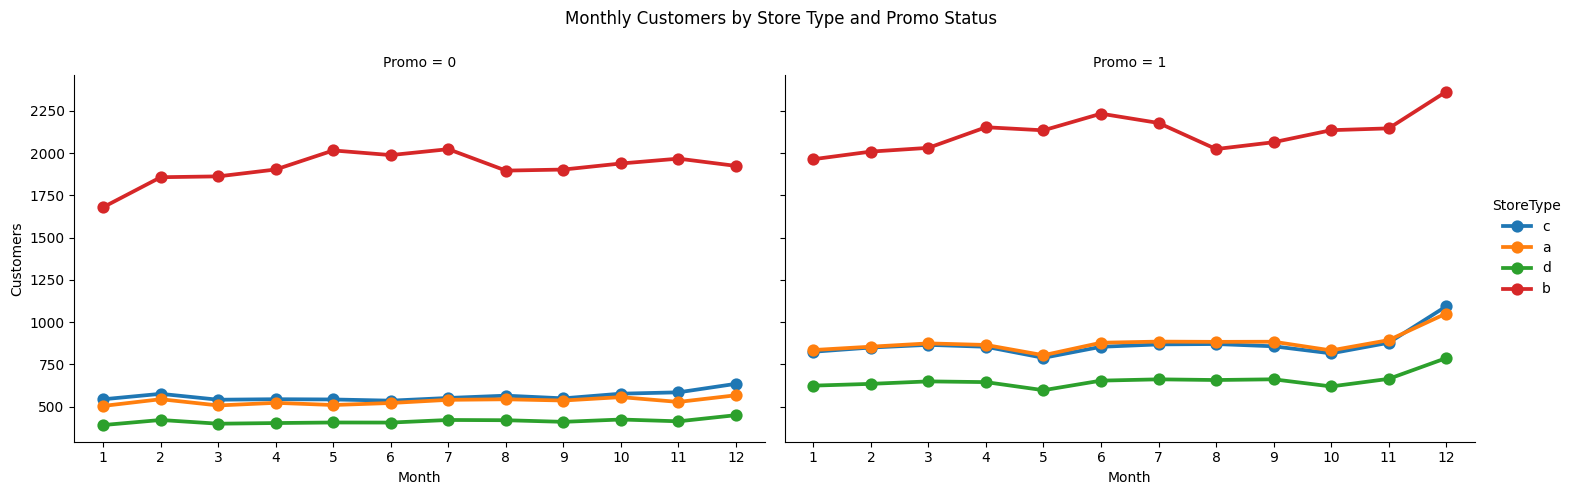

In [274]:
df['Month'] = pd.Categorical(df['Month'], categories=range(1, 13), ordered=True)

# Create factor plot
plt.figure(figsize=(10, 6))
sns.catplot(data=df, x='Month', y='Customers', hue='StoreType', col='Promo', kind='point', ci=None, aspect=1.5)
plt.subplots_adjust(top=0.85)
plt.suptitle('Monthly Customers by Store Type and Promo Status')
plt.show()

### Monthly sales per Assortment and Promo

<Figure size 1000x600 with 0 Axes>

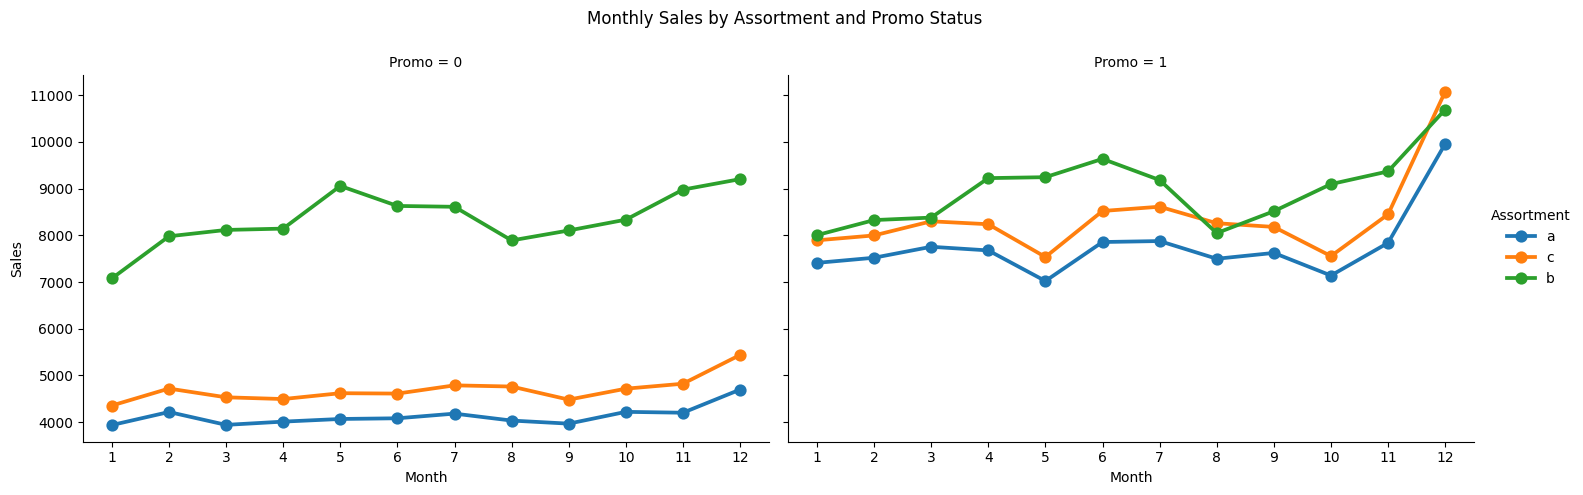

In [275]:
plt.figure(figsize=(10, 6))
sns.catplot(data=df, x='Month', y='Sales', hue='Assortment', col='Promo', kind='point', ci=None, aspect=1.5)
plt.subplots_adjust(top=0.85)
plt.suptitle('Monthly Sales by Assortment and Promo Status')
plt.show()

### Monthly customers per Assortment and Promo


<Figure size 1000x600 with 0 Axes>

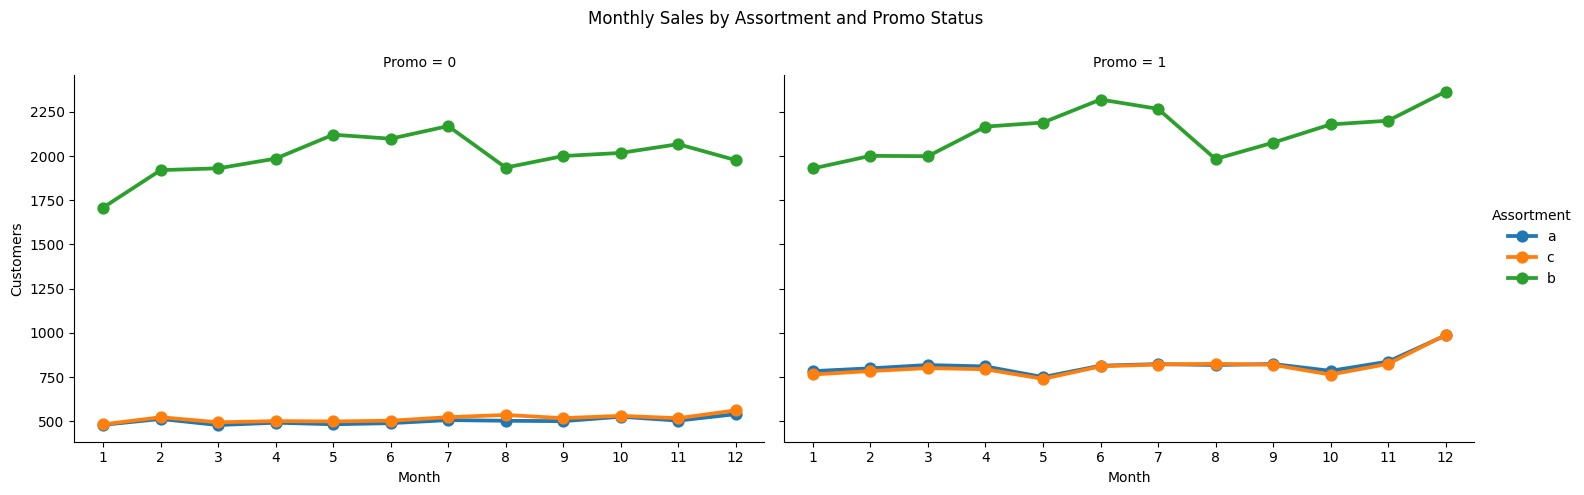

In [276]:
plt.figure(figsize=(10, 6))
sns.catplot(data=df, x='Month', y='Customers', hue='Assortment', col='Promo', kind='point', ci=None, aspect=1.5)
plt.subplots_adjust(top=0.85)
plt.suptitle('Monthly Sales by Assortment and Promo Status')
plt.show()

>Interpretation - From the graph we found that for all the stores promotion leads to increase in sales and customers. but Promotion have low impact on store type B when compare to the other store type. So promotion should be applied more in the other store type and assortment

### Sales of stores open per DayOfWeek and StoreType

In [277]:
mask = (df['Open'] != 0)

<Figure size 2000x1000 with 0 Axes>

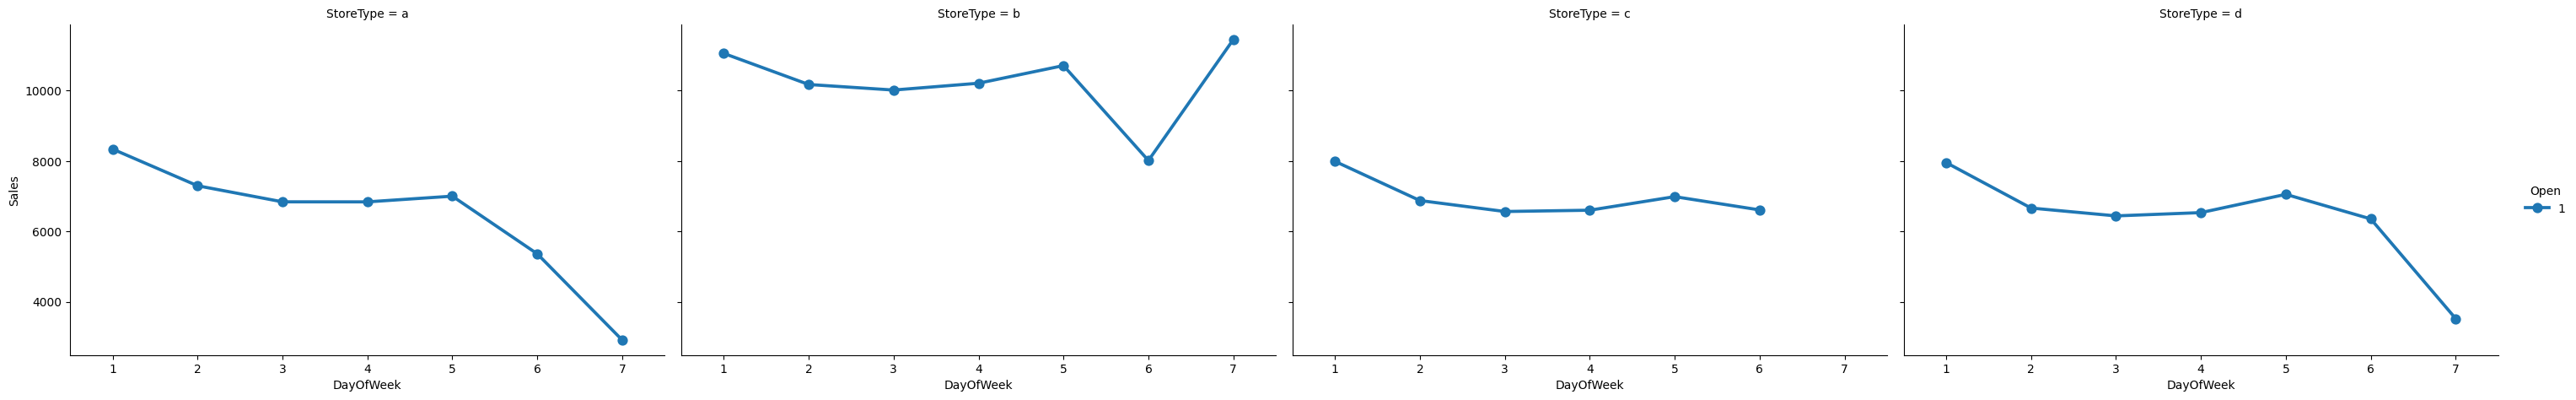

In [278]:
plt.figure(figsize=(20,10))
sns.catplot(data=df[mask], x='DayOfWeek', y='Sales', hue='Open', col='StoreType', col_order=['a','b','c','d'],kind='point', ci=None, aspect=1.5)
plt.subplots_adjust(top=0.9)
plt.show()

### Customers of stores open per DayOfWeek and StoreType

<Figure size 800x2000 with 0 Axes>

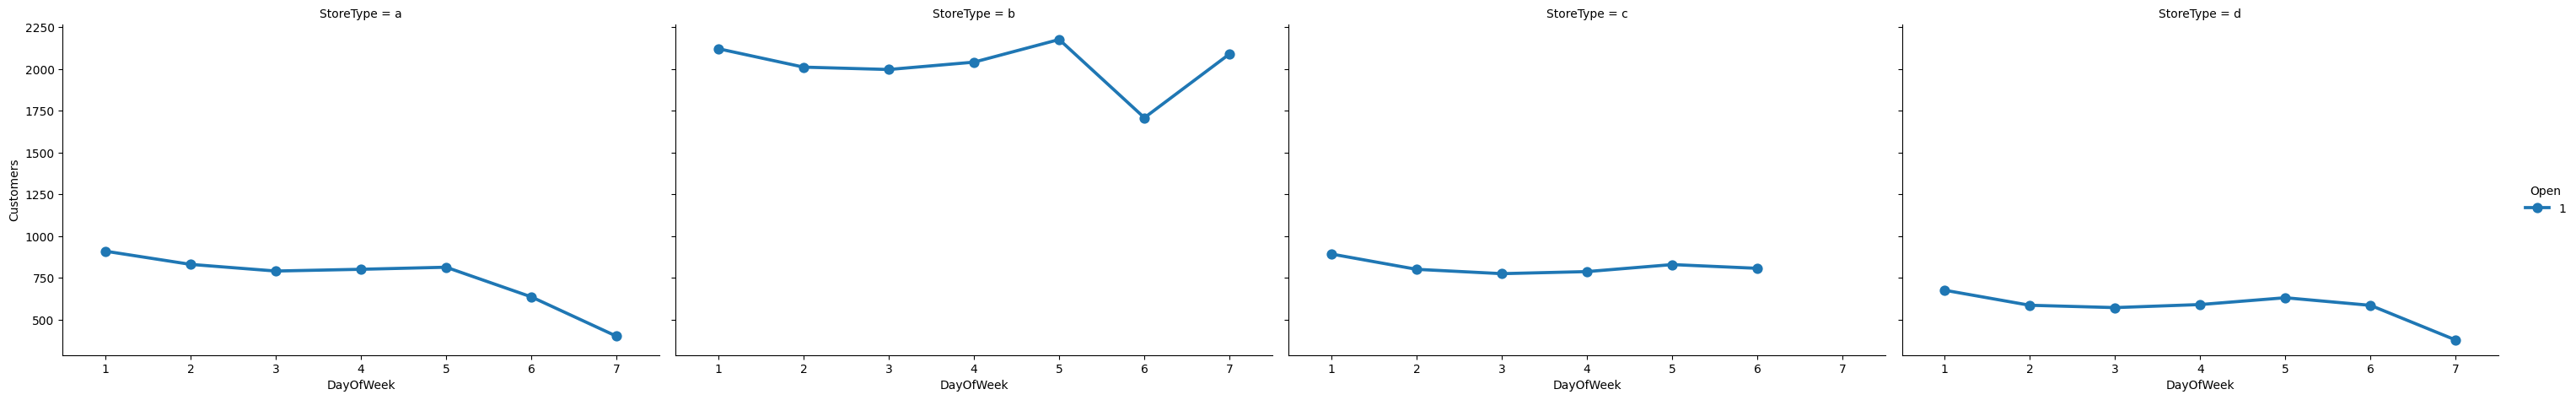

In [279]:
plt.figure(figsize=(8,20))
sns.catplot(data=df[mask], x='DayOfWeek', y='Customers', hue='Open', col='StoreType', col_order=['a','b','c','d'],kind='point', ci=None, aspect=1.5)
plt.subplots_adjust(top=0.9)
plt.show()

>Interpretation - From the above we found that store b is the most openend stores on all the weekdays and the highest sales in the sundays than the other days

### Sales of stores open per DayOfWeek and Assortment

<Figure size 1000x2000 with 0 Axes>

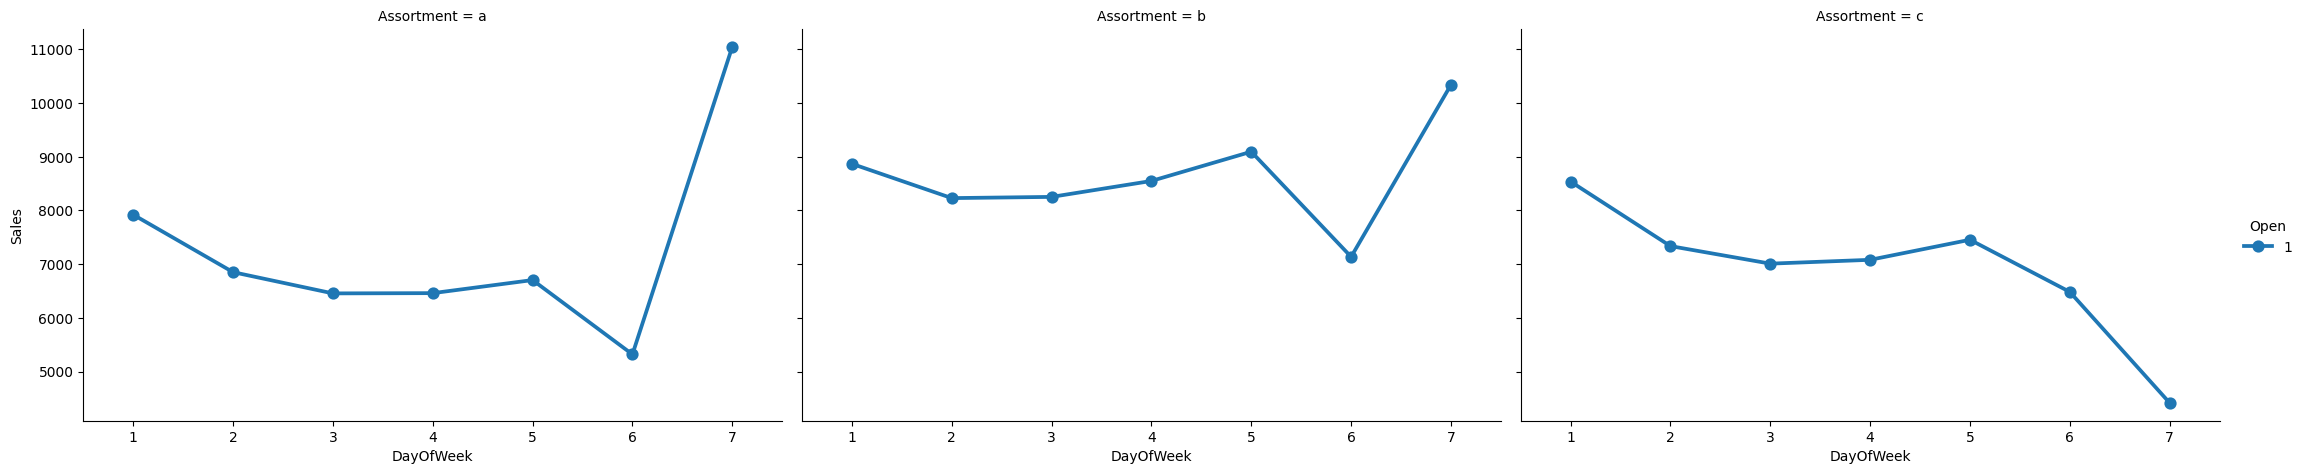

In [280]:
plt.figure(figsize=(10,20))
sns.catplot(data=df[mask], x='DayOfWeek', y='Sales', hue='Open', col='Assortment', col_order=['a','b','c'],kind='point', ci=None, aspect=1.5)
plt.subplots_adjust(top=0.9)
plt.show()

### Customers of stores open per DayOfWeek and Assortment

<Figure size 1000x2000 with 0 Axes>

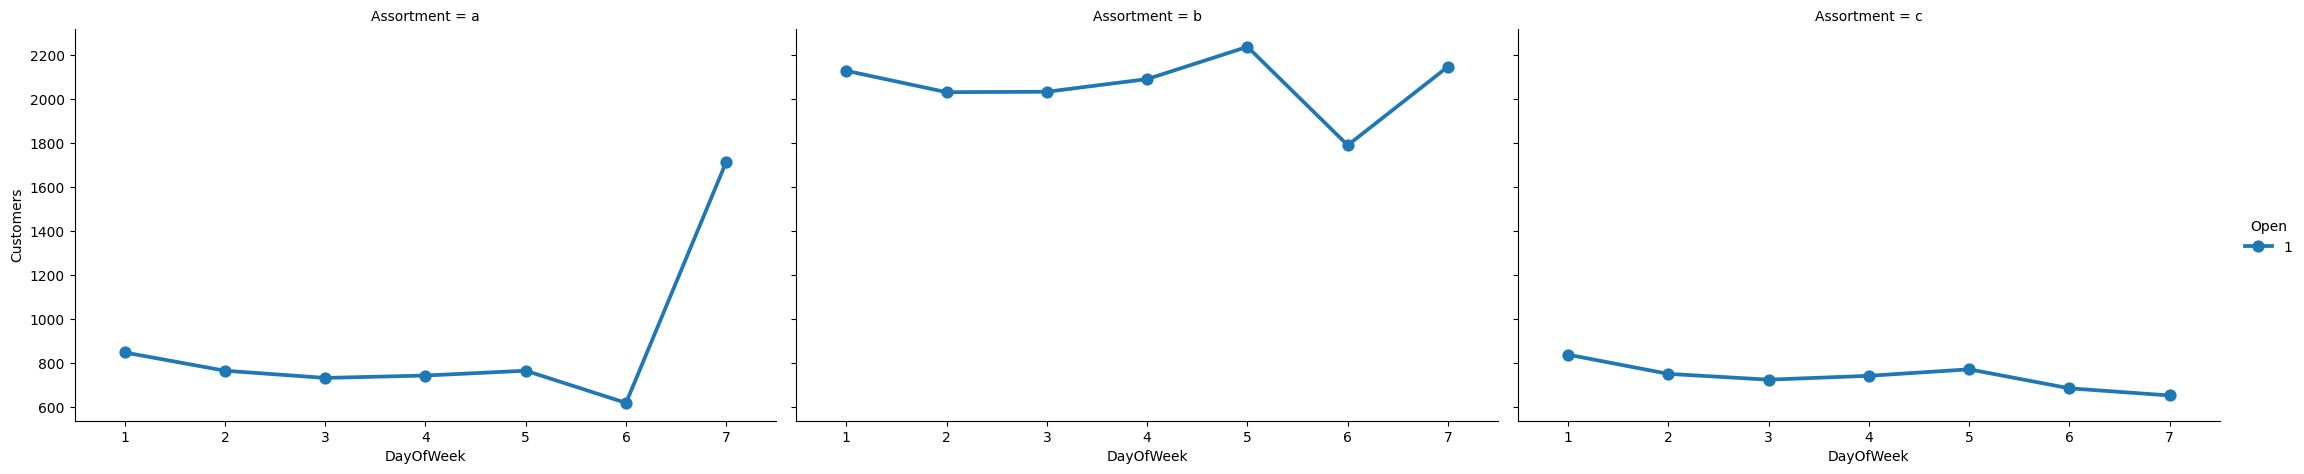

In [281]:
plt.figure(figsize=(10,20))
sns.catplot(data=df[mask], x='DayOfWeek', y='Customers', hue='Open', col='Assortment', col_order=['a','b','c'],kind='point', ci=None, aspect=1.5)
plt.subplots_adjust(top=0.9)
plt.show()

> Interpretations - Assortment a and b are the most opened assortments on all weekdays and have their highest sales on sundays than the other days. The number of cusomers increase dramatically on sundays for assortment a while it is similar with other week days for assortment b.

### Sales before, after and during Christmas

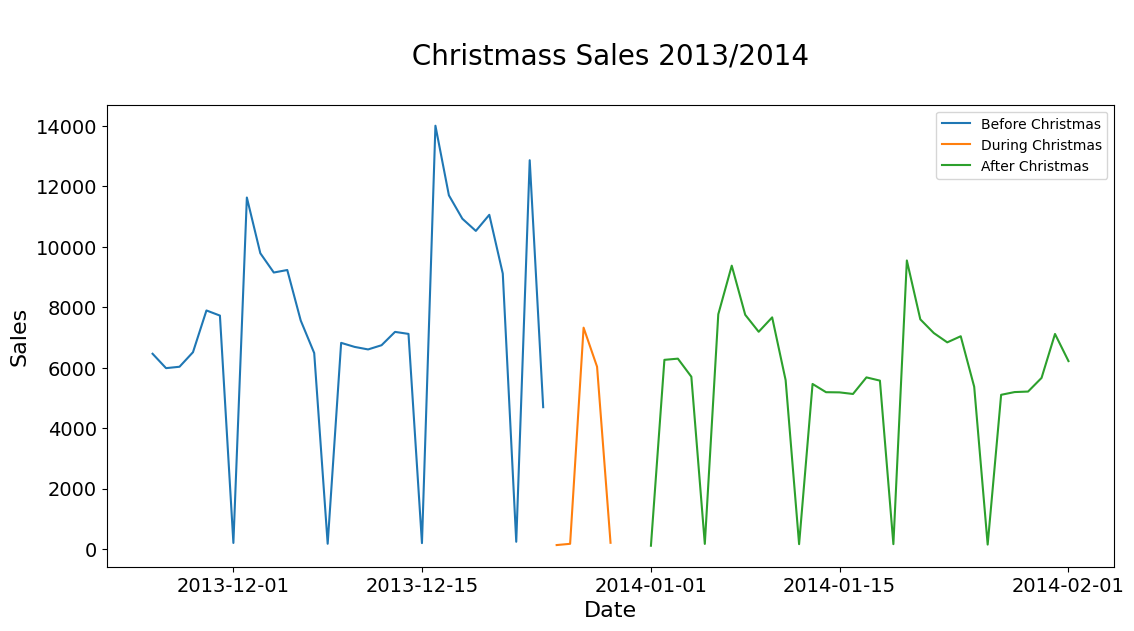

In [282]:
before_index = (train_df["Date"] >= pd.to_datetime("2013-11-25")) & (train_df["Date"] < pd.to_datetime("2013-12-25"))
before_xmass = train_df[before_index].groupby("Date").agg({"Sales": "mean"})

during_index = (train_df["Date"] >= pd.to_datetime("2013-12-25")) & (train_df["Date"] < pd.to_datetime("2013-12-30"))
during_xmass = train_df[during_index].groupby("Date").agg({"Sales": "mean"})

after_index = (train_df["Date"] >= pd.to_datetime("2014-01-01")) & (train_df["Date"] < pd.to_datetime("2014-02-02"))
after_xmass = train_df[after_index].groupby("Date").agg({"Sales": "mean"})


plt.figure(figsize=(13, 6))

sns.lineplot(x = before_xmass.index, y = before_xmass["Sales"], label='Before Christmas')
sns.lineplot(x = during_xmass.index, y = during_xmass["Sales"], label='During Christmas')
sns.lineplot(x = after_xmass.index, y = after_xmass["Sales"], label='After Christmas')

plt.title("\n Christmass Sales 2013/2014 \n", size=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(xlabel="Date", fontsize=16)
plt.ylabel(ylabel="Sales", fontsize=16)
plt.show()

>Interpretations: Here we found that sales are increases during christmas week especially 10 days before the christmas , the reason may be peoples are purchasing medicines for precaution during christmas celebration

In [470]:
df['SchoolHoliday'] = df['SchoolHoliday'].astype('string')
df['Open'] = df['Open'].astype('string')
df['PromoInterval0'] = df['PromoInterval0'].astype('string')
df['PromoInterval1'] = df['PromoInterval1'].astype('string')
df['PromoInterval2'] = df['PromoInterval2'].astype('string')
df['PromoInterval3'] = df['PromoInterval3'].astype('string')
df['weekday'] = df['weekday'].astype('string')



# Removing outliers

In [471]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844392 entries, 0 to 844391
Data columns (total 29 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   Store                         844392 non-null  int64         
 1   DayOfWeek                     844392 non-null  int64         
 2   Date                          844392 non-null  datetime64[ns]
 3   Sales                         844392 non-null  int64         
 4   Customers                     844392 non-null  int64         
 5   Open                          844392 non-null  string        
 6   Promo                         844392 non-null  int64         
 7   StateHoliday                  844392 non-null  string        
 8   SchoolHoliday                 844392 non-null  string        
 9   Year                          844392 non-null  int64         
 10  Month                         844392 non-null  int64         
 11  DayOfMonth   

In [472]:
from df_outlier_handlers import OutlierHandler
OutlierHandler=OutlierHandler(df)

In [473]:
def get_numerical_features(data):
    numerical_features = data.select_dtypes(include=['number']).columns.tolist()
    return numerical_features


In [474]:
numerical_features = get_numerical_features(df)
numerical_features

['Store',
 'DayOfWeek',
 'Sales',
 'Customers',
 'Promo',
 'Year',
 'Month',
 'DayOfMonth',
 'WeekOfYear',
 'part_of_month',
 'CompetitionDistance',
 'CompetitionOpenSinceMonth',
 'CompetitionOpenSinceYear',
 'Promo2',
 'Promo2SinceWeek',
 'Promo2SinceYear',
 'CompetitionBeforeStoreOpened']

In [475]:
Overview = OutlierHandler.getOverview(numerical_features)

In [476]:
Overview

Name of columns,CompetitionDistance,Customers,Sales,Store,Promo2SinceYear,Promo2SinceWeek,Promo2,CompetitionOpenSinceYear,CompetitionOpenSinceMonth,WeekOfYear,part_of_month,DayOfWeek,DayOfMonth,Month,Year,Promo,CompetitionBeforeStoreOpened
Min,20.0,0.0,0.0,1.0,0.0,0.0,0.0,1900.0,1.0,1.0,0.0,1.0,1.0,1.0,2013.0,0.0,0.0
Q1,710.0,519.0,4859.0,280.0,0.0,0.0,0.0,1900.0,1.0,11.0,0.0,2.0,8.0,3.0,2013.0,0.0,0.0
Median,2330.0,676.0,6369.0,558.0,0.0,0.0,0.0,2006.0,4.0,23.0,1.0,3.0,16.0,6.0,2014.0,0.0,0.0
Q3,6910.0,893.0,8360.0,837.0,2012.0,22.0,1.0,2011.0,9.0,35.0,2.0,5.0,23.0,8.0,2014.0,1.0,1.0
Max,75860.0,7388.0,41551.0,1115.0,2015.0,50.0,1.0,2015.0,12.0,52.0,2.0,7.0,31.0,12.0,2015.0,1.0,1.0
IQR,6200.0,374.0,3501.0,557.0,2012.0,22.0,1.0,111.0,8.0,24.0,2.0,3.0,15.0,5.0,1.0,1.0,1.0
Lower fence,-8590.0,-42.0,-392.5,-555.5,-3018.0,-33.0,-1.5,1733.5,-11.0,-25.0,-3.0,-2.5,-14.5,-4.5,2011.5,-1.5,-1.5
Upper fence,16210.0,1454.0,13611.5,1672.5,5030.0,55.0,2.5,2177.5,21.0,71.0,5.0,9.5,45.5,15.5,2015.5,2.5,2.5
Skew,3.603199,2.78811,1.593922,0.000414,0.005267,1.010442,0.005263,-0.759132,0.310794,0.262283,-0.163498,0.0193,0.011117,0.2577,0.300875,0.215839,0.781021
Number_of_outliers,83662,40853,30769,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Handling outliers

### calculating Outliers percentage:

In [477]:
def find_outlier_percentage(data):
    """
    Calculate the outlier percentage for numerical variables and label categorical features.

    Parameters:
        data (DataFrame): Input DataFrame.

    Returns:
        dict: Dictionary containing outlier percentages for numerical variables and a list of categorical features.
    """
    outlier_percentage = {}
    categorical_features = []

    # Loop through each column in the DataFrame
    for column in data.columns:
        # Check if the column contains numerical data
        if data[column].dtype in ['int64', 'float64']:
            # Calculate the outlier percentage using the IQR method
            Q1 = data[column].quantile(0.25)
            Q3 = data[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_fence = Q1 - 1.5 * IQR
            upper_fence = Q3 + 1.5 * IQR
            outlier_count = ((data[column] < lower_fence) | (data[column] > upper_fence)).sum()
            outlier_percentage[column] = (outlier_count / len(data)) * 100
        else:
            # Categorical feature
            categorical_features.append(column)

    return {"Outlier Percentage": outlier_percentage, "Categorical Features": categorical_features}



In [478]:
# Example usage:
# Assuming 'df' is your DataFrame
outlier_info = find_outlier_percentage(df)
print("Outlier Percentage:")
for column, percentage in outlier_info["Outlier Percentage"].items():
    print(f"{column}: {percentage:.2f}%")
print("Categorical Features:", outlier_info["Categorical Features"])


Outlier Percentage:
Store: 0.00%
DayOfWeek: 0.00%
Sales: 3.64%
Customers: 4.84%
Promo: 0.00%
Year: 0.00%
Month: 0.00%
DayOfMonth: 0.00%
WeekOfYear: 0.00%
part_of_month: 0.00%
CompetitionDistance: 9.91%
CompetitionOpenSinceMonth: 0.00%
CompetitionOpenSinceYear: 0.00%
Promo2: 0.00%
Promo2SinceWeek: 0.00%
Promo2SinceYear: 0.00%
CompetitionBeforeStoreOpened: 0.00%
Categorical Features: ['Date', 'Open', 'StateHoliday', 'SchoolHoliday', 'weekday', 'StoreType', 'Assortment', 'PromoInterval', 'PromoInterval0', 'PromoInterval1', 'PromoInterval2', 'PromoInterval3']


### Replacing outlier with fence values

In [479]:
def replace_outliers_with_fence(data, k=1.5):
    """
    Replace outliers in numerical columns with the upper or lower fence using the IQR method.

    Parameters:
        data (DataFrame): Input DataFrame.
        k (float): Multiplier for determining the threshold for outliers (default: 1.5).

    Returns:
        DataFrame: DataFrame with outliers replaced.
    """
    for column in data.select_dtypes(include=['number']).columns:
        # Calculate quartiles
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        # Calculate IQR and fences
        IQR = Q3 - Q1
        lower_fence = Q1 - k * IQR
        upper_fence = Q3 + k * IQR
        # Replace outliers with the fence
        data[column] = data[column].mask(data[column] < lower_fence, lower_fence)
        data[column] = data[column].mask(data[column] > upper_fence, upper_fence)
    return data

# Example usage:
# Assuming 'df' is your DataFrame
df = replace_outliers_with_fence(df)


In [480]:
# Example usage:
# Assuming 'df' is your DataFrame
outlier_info = find_outlier_percentage(df)
print("Outlier Percentage:")
for column, percentage in outlier_info["Outlier Percentage"].items():
    print(f"{column}: {percentage:.2f}%")
print("Categorical Features:", outlier_info["Categorical Features"])


Outlier Percentage:
Store: 0.00%
DayOfWeek: 0.00%
Sales: 0.00%
Customers: 0.00%
Promo: 0.00%
Year: 0.00%
Month: 0.00%
DayOfMonth: 0.00%
WeekOfYear: 0.00%
part_of_month: 0.00%
CompetitionDistance: 0.00%
CompetitionOpenSinceMonth: 0.00%
CompetitionOpenSinceYear: 0.00%
Promo2: 0.00%
Promo2SinceWeek: 0.00%
Promo2SinceYear: 0.00%
CompetitionBeforeStoreOpened: 0.00%
Categorical Features: ['Date', 'Open', 'StateHoliday', 'SchoolHoliday', 'weekday', 'StoreType', 'Assortment', 'PromoInterval', 'PromoInterval0', 'PromoInterval1', 'PromoInterval2', 'PromoInterval3']


In [490]:
df['SchoolHoliday'] = df['SchoolHoliday'].astype(int)
df['Open'] = df['Open'].astype(int)
df['PromoInterval0'] = df['PromoInterval0'].astype(int)
df['PromoInterval1'] = df['PromoInterval1'].astype(int)
df['PromoInterval2'] = df['PromoInterval2'].astype(int)
df['PromoInterval3'] = df['PromoInterval3'].astype(int)
df['weekday'] = df['weekday'].astype(int)

In [492]:
unique_values_df(df)

,Column,Unique values
0,Store,"[562, 769, 733, 423, 85, 262, 335, 682, 1097, ..."
1,DayOfWeek,"[6, 2, 3, 5, 1, 4, 7]"
2,Date,"[2014-04-16 00:00:00, 2015-01-13 00:00:00, 201..."
3,Sales,"[13611.5, 5674.0, 5558.0, 5483.0, 6049.0, 6214..."
4,Customers,"[1454, 560, 576, 603, 571, 555, 566, 517, 539,..."
5,Open,[1]
6,Promo,"[0, 1]"
7,StateHoliday,"[0, a, b, c]"
8,SchoolHoliday,"[0, 1]"
9,Year,"[2013, 2014, 2015]"


In [493]:
df.to_csv(r"D:\Pharmaceutical\Notebook\clean_data\train_df.csv",index=False)


### Now extracting Features for test data set and removing outliers

In [482]:
test_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'Year', 'Month', 'DayOfMonth', 'WeekOfYear', 'weekday',
       'part_of_month'],
      dtype='object')

In [483]:
convert_to_datetime(test_df, ['Date'])

In [484]:
test_df['Year'] = test_df['Date'].apply(lambda x: x.year)
test_df['Month'] = test_df['Date'].apply(lambda x: x.month)
test_df['DayOfMonth'] = test_df['Date'].apply(lambda x: x.day)
test_df['WeekOfYear'] =test_df['Date'].apply(lambda x: x.weekofyear)
test_df['weekday'] =test_df['DayOfWeek'].apply(lambda x: 0 if (x in [6, 7]) else 1)

In [485]:
test_df=extract_part_of_month(test_df)

In [486]:
test_df.head()

,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,DayOfMonth,WeekOfYear,weekday,part_of_month
0,1,4,2015-09-17,1.0,1,0,0,2015,9,17,38,1,1
1,3,4,2015-09-17,1.0,1,0,0,2015,9,17,38,1,1
2,7,4,2015-09-17,1.0,1,0,0,2015,9,17,38,1,1
3,8,4,2015-09-17,1.0,1,0,0,2015,9,17,38,1,1
4,9,4,2015-09-17,1.0,1,0,0,2015,9,17,38,1,1


In [487]:
df2 = pd.merge(test_df, store_df, how='inner', on='Store')

In [494]:
df2['SchoolHoliday'] = df2['SchoolHoliday'].astype('string')
df2['Open'] = df2['Open'].astype('string')
df2['PromoInterval0'] = df2['PromoInterval0'].astype('string')
df2['PromoInterval1'] = df2['PromoInterval1'].astype('string')
df2['PromoInterval2'] = df2['PromoInterval2'].astype('string')
df2['PromoInterval3'] = df2['PromoInterval3'].astype('string')
df2['weekday'] = df2['weekday'].astype('string')


In [498]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35093 entries, 0 to 35092
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Store                         35093 non-null  int64         
 1   DayOfWeek                     35093 non-null  int64         
 2   Date                          35093 non-null  datetime64[ns]
 3   Open                          35093 non-null  string        
 4   Promo                         35093 non-null  int64         
 5   StateHoliday                  35093 non-null  object        
 6   SchoolHoliday                 35093 non-null  string        
 7   Year                          35093 non-null  int64         
 8   Month                         35093 non-null  int64         
 9   DayOfMonth                    35093 non-null  int64         
 10  WeekOfYear                    35093 non-null  int64         
 11  weekday                     

In [495]:
df2.columns.to_list()

['Store',
 'DayOfWeek',
 'Date',
 'Open',
 'Promo',
 'StateHoliday',
 'SchoolHoliday',
 'Year',
 'Month',
 'DayOfMonth',
 'WeekOfYear',
 'weekday',
 'part_of_month',
 'StoreType',
 'Assortment',
 'CompetitionDistance',
 'CompetitionOpenSinceMonth',
 'CompetitionOpenSinceYear',
 'Promo2',
 'Promo2SinceWeek',
 'Promo2SinceYear',
 'PromoInterval',
 'CompetitionBeforeStoreOpened',
 'PromoInterval0',
 'PromoInterval1',
 'PromoInterval2',
 'PromoInterval3']

In [496]:
outlier_info = find_outlier_percentage(df2)
print("Outlier Percentage:")
for column, percentage in outlier_info["Outlier Percentage"].items():
    print(f"{column}: {percentage:.2f}%")
print("Categorical Features:", outlier_info["Categorical Features"])


Outlier Percentage:
Store: 0.00%
DayOfWeek: 0.00%
Promo: 0.00%
Year: 0.00%
Month: 0.00%
DayOfMonth: 0.00%
WeekOfYear: 0.00%
part_of_month: 0.00%
CompetitionDistance: 8.99%
CompetitionOpenSinceMonth: 0.00%
CompetitionOpenSinceYear: 0.00%
Promo2: 0.00%
Promo2SinceWeek: 0.00%
Promo2SinceYear: 0.00%
CompetitionBeforeStoreOpened: 0.00%
Categorical Features: ['Date', 'Open', 'StateHoliday', 'SchoolHoliday', 'weekday', 'StoreType', 'Assortment', 'PromoInterval', 'PromoInterval0', 'PromoInterval1', 'PromoInterval2', 'PromoInterval3']


In [499]:
numerical_features = get_numerical_features(df2)
numerical_features

['Store',
 'DayOfWeek',
 'Promo',
 'Year',
 'Month',
 'DayOfMonth',
 'WeekOfYear',
 'part_of_month',
 'CompetitionDistance',
 'CompetitionOpenSinceMonth',
 'CompetitionOpenSinceYear',
 'Promo2',
 'Promo2SinceWeek',
 'Promo2SinceYear',
 'CompetitionBeforeStoreOpened']

In [500]:
def replace_outliers_with_fence(data, k=1.5):
    """
    Replace outliers in numerical columns with the upper or lower fence using the IQR method.

    Parameters:
        data (DataFrame): Input DataFrame.
        k (float): Multiplier for determining the threshold for outliers (default: 1.5).

    Returns:
        DataFrame: DataFrame with outliers replaced.
    """
    for column in data.select_dtypes(include=['number']).columns:
        # Calculate quartiles
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        # Calculate IQR and fences
        IQR = Q3 - Q1
        lower_fence = Q1 - k * IQR
        upper_fence = Q3 + k * IQR
        # Replace outliers with the fence
        data[column] = data[column].mask(data[column] < lower_fence, lower_fence)
        data[column] = data[column].mask(data[column] > upper_fence, upper_fence)
    return data

# Example usage:
# Assuming 'df' is your DataFrame
df2 = replace_outliers_with_fence(df2)


In [501]:
outlier_info = find_outlier_percentage(df2)
print("Outlier Percentage:")
for column, percentage in outlier_info["Outlier Percentage"].items():
    print(f"{column}: {percentage:.2f}%")
print("Categorical Features:", outlier_info["Categorical Features"])

Outlier Percentage:
Store: 0.00%
DayOfWeek: 0.00%
Promo: 0.00%
Year: 0.00%
Month: 0.00%
DayOfMonth: 0.00%
WeekOfYear: 0.00%
part_of_month: 0.00%
CompetitionDistance: 0.00%
CompetitionOpenSinceMonth: 0.00%
CompetitionOpenSinceYear: 0.00%
Promo2: 0.00%
Promo2SinceWeek: 0.00%
Promo2SinceYear: 0.00%
CompetitionBeforeStoreOpened: 0.00%
Categorical Features: ['Date', 'Open', 'StateHoliday', 'SchoolHoliday', 'weekday', 'StoreType', 'Assortment', 'PromoInterval', 'PromoInterval0', 'PromoInterval1', 'PromoInterval2', 'PromoInterval3']


In [434]:
#df2.drop("Id",axis=1, inplace=True)

In [504]:
convert_to_string(test_df, ['StateHoliday'])

In [505]:
df2['SchoolHoliday'] = df2['SchoolHoliday'].astype(int)
df2['Open'] = df2['Open'].astype('string')
df2['PromoInterval0'] = df2['PromoInterval0'].astype(int)
df2['PromoInterval1'] = df2['PromoInterval1'].astype(int)
df2['PromoInterval2'] = df2['PromoInterval2'].astype(int)
df2['PromoInterval3'] = df2['PromoInterval3'].astype(int)
df2['weekday'] = df2['weekday'].astype(int)


In [507]:
unique_values_df(df2)

,Column,Unique values
0,Store,"[262, 769, 562, 453, 863, 310, 209, 1045, 867,..."
1,DayOfWeek,"[4, 3, 2, 1, 6, 5, 7]"
2,Date,"[2015-08-24 00:00:00, 2015-08-27 00:00:00, 201..."
3,Open,[1.0]
4,Promo,"[0, 1]"
5,StateHoliday,"[0, a]"
6,SchoolHoliday,"[1, 0]"
7,Year,[2015]
8,Month,"[8, 9]"
9,DayOfMonth,"[1, 3, 4, 5, 10, 11, 7, 12, 17, 14, 8, 15, 2, ..."


In [506]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35093 entries, 0 to 35092
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Store                         35093 non-null  int64         
 1   DayOfWeek                     35093 non-null  int64         
 2   Date                          35093 non-null  datetime64[ns]
 3   Open                          35093 non-null  string        
 4   Promo                         35093 non-null  int64         
 5   StateHoliday                  35093 non-null  object        
 6   SchoolHoliday                 35093 non-null  int32         
 7   Year                          35093 non-null  int64         
 8   Month                         35093 non-null  int64         
 9   DayOfMonth                    35093 non-null  int64         
 10  WeekOfYear                    35093 non-null  int64         
 11  weekday                     

In [508]:
df2.to_csv(r'D:\Pharmaceutical\Notebook\clean_data\test_df.csv',index=False)

In [435]:
df.shape

(844392, 29)

In [437]:
df2.shape

(35093, 27)